This version finds all nearest neighbor tours and then tries to improve each one by perturbation
- check pairs of nodes, starting with those which are far apart
- probabalistically choose if more than one perturbation can reduce size
- the idea is to get a rough statistical understanding of how this approach is affected by problem size
- a descendant of 002 and 006

# TSPLIB Euclidean tours with solutions

- a280
- berlin52
- ch130
- ch150
- eil101
- eil51
- eil76
- kroA100
- kroC100
- kroD100
- lin105
- pcb442
- pr1002
- pr2392
- pr76
- rd100
- st70
- tsp225

In [98]:
import glob                               # for searching directories
import os.path                            # for checking file existence
import math                               # for distance calculations
import statistics                         # for statistics
import matplotlib.pyplot as plt           # for visual display
import sys                                # for limit values
from random import choices                # for choosing random delta

In [99]:
def getTourNames():
    '''get names of Euclidean tours we know the exact solutions to'''
    
    # first by size, then by name
    
    return [
        'eil51',
        'berlin52',
        'st70',
        'eil76',
        'pr76',
        'kroA100',
        'kroC100',
        'kroD100',
        'rd100',
        'eil101',
        'lin105',
        'ch130',
        'ch150',
        'tsp225',
        'a280',
        'pcb442',
# these work to creat exhaustive nearest neighbor tours in more-or-less reasonable time
# - however the time to improve them can take too long to rapidly check how effective they are
#        'pr1002',
#        'pr2392',
    ]    

In [100]:
# global scope, so we don't have to worry about passing them around
# - note TSPLIB problems sets are 1-based but Python lists are 0-based

tspNodeCnt = None    # an integer: the number of nodes in a tour
tspOptTour = None    # a tuple: ( length, [nodes] )
tspNodeCoor = None   # a list: [ node, x-coor, y-coor ]

# for improvement statistics

revCnt = None        # an integer: the number of times reversing a string of nodes made a tour shorter
rolCnt = None        # an integer: the number of times rotating a string of nodes left made a tour shorter
rorCnt = None        # an integer: the number of times rotating a string of nodes right made a tour shorter
excCnt = None        # an integer: the number of times exchanging two nodes made a tour shorter
mulCnt = None        # an integer: the number of times two or more changes made a tour shorter

loopCnt = None       # an integer: the number of times the perturbation loop was executed for one tour
effectCnt = None     # an integer: the number of times a perturbation shortened a tour
ineffectCnt = None   # an integer: the number of times a perturbation did not shorten a tour
adjCnt = None        # an integer: the number of times a change to two adjacent nodes shortened a tour
nonadjCnt = None     # an integer: the number of time a change to two non-adjacent nodes shortened a tour

allLoops = None      # a list: counts of number of times a tour perturbation loop was executed
allEff = None        # a list: count of number of times a perturbation of a tour was effecive
allnoEff = None      # a list: count of number of times a perturbation of a loop was ineffective

allRev = None        # a list: count of number of times reversing was effective
allRol = None        # a list: count of number of times rotation left was effective
allRor = None        # a list: count of number of times rotation right was effective
allExc = None        # a list: count of number of time exchanging was effective
allMul = None        # a list: count of number of times more than one change was effective

In [101]:
def waitkey():

    key = input('Press [ENTER] to continue, [Q] to quit ')
    if 'Q' != key.upper():
        print( '\n' )
    else:
        sys.exit() 


In [102]:
def euclidean(p0, p1):
    '''Euclidean distance between two points'''
    node0 = tspNodeCoor[ p0-1 ]
    node1 = tspNodeCoor[ p1-1 ]

    dx = node0[1] - node1[1]
    dy = node0[2] - node1[2]

    return round( math.sqrt( dx * dx + dy * dy ) )

def tourLength(tour):
    '''find length of tour'''
    tourlen = euclidean( tour[0], tour[-1] )             # distance between first and last points
    for node in range(1, len(tour)):                     # ...plus all the rest of the points
        tourlen += euclidean( tour[node-1], tour[node] )
    return tourlen
    

In [103]:
# functions and variables related to displays

def getDisplayCoor(tour):
    '''make sequences of X and Y coordinates for display'''
     
    xpts = []
    ypts = []
    
    for node in tour:
        nn, xc, yc = tspNodeCoor[ node-1 ]
        xpts.append( xc )          # x-coordinate
        ypts.append (yc )          # y-coordinate
        
    xpts.append( xpts[0] )         # last node == first node
    ypts.append( ypts[0] )
    
    return ( xpts, ypts )

def getOptCoor():
    '''get display coordinates for problem set nodes'''
    # the nodes of the problem set (in monotonic order)
    xnodes, ynodes = getDisplayCoor( range(1, len(tspOptTour[1])+1) )
    # the nodes of the optimal tour (in optimal order)
    xopts, yopts = getDisplayCoor( tspOptTour[1] )
    return [ xnodes, ynodes, xopts, yopts ]

def displayOptTour(name):
    '''display the optimal tour'''
    # get display coordinates
    xnodes, ynodes, xopt, yopts = getOptCoor()
    # show tour
    plt.figure( figsize=(12,10), dpi=109 )
    plt.title( name )
    plt.scatter( xnodes, ynodes )
    plt.plot( xopts, yopts, c='r' )
    plt.show() 
    
def tourDiff(foundlen, optlen):
    '''percentage difference in found tour to optimal tour'''
    diff = ( foundlen / optlen ) * 100
    return f'{round(diff, 2)}%'


In [104]:
# display min, max and optimal tours

def displayTours(name, mintour, maxtour, opttour, allshortest):
    '''display min, max and optimal tours'''
    # get display coordinates
    xnodes, ynodes, xopts, yopts = getOptCoor()
    xmins, ymins = getDisplayCoor( mintour )
    xmaxs, ymaxs = getDisplayCoor( maxtour )
    shortx, shorty = getDisplayCoor( allshortest )
    # show them
    plt.figure( figsize=(12,10), dpi=109 )
    plt.title( name )
    plt.scatter( xnodes, ynodes )
    plt.scatter( shortx, shorty, c='y', s=100 )
    # these are on top of each other
    plt.plot( xmaxs, ymaxs, c='b' )
    plt.plot( xmins, ymins, c='g' )
    plt.plot( xopts, yopts, c='r' )
    plt.show()
    

In [105]:
def showCounts():
    '''show minimum, maximum and average counts'''
    global allLoops, allEff, allnoEff
    global allRev, allRol, allRor, allExc, allMul

    def showcount(tag, this):
        ave = round( statistics.mean(this) )
        print( f'{tag}: {min(this): 7}  {max(this): 7}  {ave: 7}' )
        
    print( '\n                        Min      Max      Ave')
    showcount( '\nPerturbation loops', allLoops )
    showcount( '         Effective', allEff )
    showcount( '       Ineffective', allnoEff )
    
    showcount( '\n          Reversal', allRev )
    showcount( '       Rotate Left', allRol )
    showcount( '      Rotate Right', allRor )
    showcount( '          Exchange', allExc )
    showcount( '         Multiples', allMul )

In [106]:
def showLens(tours):
    '''display lengths of all tours'''
    
    # dictionary key = tour length
    # dictionary value = first node in every tour with that length

    lengths = dict()
    for tour in tours:
        if not tour[0] in lengths:
            lengths[ tour[0] ] = []
        lengths[tour[0]].append( tour[1][0] )
        
    # show the dictionary
    # - the idea is to see where tour reduction "stalled out"
    # - which might give us some ideas of what to do about that
    
    for length in lengths:
        samelength = lengths[ length ]
        print( f"{len(samelength): 3} tours of length {length: 6}:\t{samelength}" )

    print( f"\n{len(tours): 5} tours of {len(lengths)} different lengths" )


In [107]:
def showTours(name, tours):
    
    mintomax = sorted( tours, key=lambda x: x[0] )
    mintour = mintomax[ 0 ]
    maxtour = mintomax[ -1 ]
    minlen = mintour[ 0 ]
    maxlen = maxtour[ 0 ]
    optlen = tspOptTour[ 0 ]
    
    shortest = [ t[1][0] for t in tours if t[0] == mintour[0] ]
    
    displayTours( name, mintour[1], maxtour[1], tspOptTour[1], shortest )
    
    # some statistics regarding this tour

    print( f'(red)   Optimal  Tour: {optlen: 6}   {tourDiff(optlen, optlen)}')
    print( f'(grn) Minimum NN Tour: {minlen: 6}   {tourDiff(minlen, optlen)}   (ylw) Start Node')
    print( f'(blu) Maximum NN Tour: {maxlen: 6}   {tourDiff(maxlen, optlen)}\n')
    
    avelen = round( statistics.mean([elem[0] for elem in mintomax]) )
    print( f'  Average Tour Length: {avelen: 6}   {tourDiff(avelen, optlen)}\n' )
    
    return mintomax

In [108]:
def loadTour(directory, probname):
    '''read and setup one tour problem and its solution'''
    global tspNodeCnt, tspNodeCoor, tspOptTour

    tspNodeCnt = tspOptTour = tspNodeCoor = None

    # the solution (if there is a solution set, there is a problem set - but the reverse is not always true)

    solution = f'{directory}\\{probname}.opt.tour'
    if os.path.isfile(solution):
        with open(solution) as f:
            tsp_data = f.readlines()
    else:
        return False 
        
    opttour = []
    collecting = False
    for line in tsp_data:
        if not collecting:
            collecting = line.find('TOUR_SECT') > -1
 
        elif line.find('EOF') < 0:
            nodes = line.split()                     # sometimes multiple nodes are on one line
            for node in nodes:
                i = int( node )
                if i > 0:                            # negative one signifies end of nodes
                    opttour.append( i )
    
    # the associated problem (we want only nice Euclidean 2D problems, BTW)
    
    problem = f'{directory}\\{probname}.tsp'
    if os.path.isfile(problem):
        with open(problem) as f:
            tsp_data = f.readlines()
    else:
        return False
        
    nodes = []
    collecting = False
    for line in tsp_data:
        if not collecting:
            collecting = line.find('NODE_COORD_SECTION') > -1

        # annoyingly enough, some of these files end in chr('0x0A'), not the string 'EOF'
        elif ord(line[0]) > 20 and line.find('EOF') < 0:
            words = line.split()
            # 'x.0' floats are a nuisance
            nodes.append( [int(words[0]), float(words[1]), float(words[2]) ] )

    # how many nodes in this tour
    tspNodeCnt = len( nodes )
            
    # a list of [ node, x-coor, y-coor ]
    tspNodeCoor = nodes

    # a tuple of ( length, [nodes] )
    tspOptTour = ( tourLength(opttour), opttour )

    return True
   

In [109]:
def perturb(tour, ndxnode1, ndxnode2):
    '''find the greatest reduction in tour size'''
    global revCnt, rolCnt, rorCnt, excCnt, mulCnt
            
    # find the indices of the nodes affected by any change we propose to try
    
    ndxpred1 = ndxnode1-1 if ndxnode1 > 1 else tspNodeCnt
    ndxsucc1 = ndxnode1+1 if ndxnode1 < tspNodeCnt else 1
    
    ndxpred2 = ndxnode2-1 if ndxnode2 > 1 else tspNodeCnt
    ndxsucc2 = ndxnode2+1 if ndxnode2 < tspNodeCnt else 1
    
    # find the nodes at those indices
    
    pred1 = tour[1][ndxpred1-1]
    node1 = tour[1][ndxnode1-1]
    succ1 = tour[1][ndxsucc1-1]
    
    pred2 = tour[1][ndxpred2-1]
    node2 = tour[1][ndxnode2-1]
    succ2 = tour[1][ndxsucc2-1]
    
    # assume no change results in a shorter tour
    
    changes = 0
    
    # try reversing the order of the nodes:
    # pred1 - node1 succ1 ... pred2 node2 - succ2 ->
    # pred1 + node2 pred2 ... succ1 node1 + succ2
    
    # how long are the two edges we're going to break ?
    
    p1n1 = euclidean( pred1, node1 )
    n2s2 = euclidean( node2, succ2 )
    orglen = p1n1 + n2s2
    
    # how long are the two edges we're going to make ?
    
    p1n2 = euclidean( pred1, node2 )
    n1s2 = euclidean( node1, succ2 )
    newlen = p1n2 + n1s2
    
    # does this make the tour shorter ?
    
    revdlt = newlen - orglen
    if revdlt < 0:
        changes |= 1

    # if the two nodes are adjacent, all changes we might make are equivalent
    # - otherwise, we want to try three more possibilities
    
    if succ1 != node2:
    
        # try rotating the node string one position left:
        # pred1 - node1 - succ1 ... pred2 node2 - succ2 ->
        # pred1 + succ1 ... pred2 node2 + node1 + succ2

        n1s1 = euclidean( node1, succ1 )
        orglen = p1n1 + n1s1 + n2s2

        p1s1 = euclidean( pred1, succ1 )
        n2n1 = euclidean( node2, node1 )
        newlen = p1s1 + n2n1 + n1s2

        roldlt = newlen - orglen
        if roldlt < 0:
            changes |= 2

        # try rotating the node string one position right:
        # pred1 - node1 succ1 ... pred2 - node2 - succ2 ->
        # pred1 + node2 + node1 succ1 ... pred2 + succ2

        p2n2 = euclidean( pred2, node2 )
        orglen = p1n1 + p2n2 + n2s2

        p2s2 = euclidean( pred2, succ2 )
        newlen = p1n2 + n2n1 + p2s2

        rordlt = newlen - orglen
        if rordlt < 0:
            changes |= 4
 
        # try exchanging node1 and node2
        # pred1 - node1 - succ1 ... pred2 - node2 - succ2 ->
        # pred1 + node2 + succ1 ... pred2 + node1 + succ2

        orglen = p1n1 + n1s1 + p2n2 + n2s2

        n2s1 = euclidean( node2, succ1 )
        p2n1 = euclidean( pred2, node1 )
        newlen = p1n2 + n2s1 + p2n1 + n1s2

        excdlt = newlen - orglen
        if excdlt < 0:
            changes |= 8
              
    # did any change make a difference ?
    
    if changes != 0:
        
        #  did more than one change make a difference ?
        if not changes in [1, 2, 4, 8]:
            mulCnt += 1

        # which change made a difference ?
        
        # rev ?
        if changes == 1:
            changetype = "reverse"
        # rol ?
        elif changes == 2:
            changetype = "rotleft"
        # rev and rol ?
        elif changes == 3:
            changetype = choices(["reverse", "rotleft"], [revdlt, roldlt])[0]
        # ror ?
        elif changes == 4:
            changetype = "rotright"
        # rev and ror ?
        elif changes == 5:
            changetype = choices(["reverse", "rotright"], [revdlt, rordlt])[0]
        # rol and ror ?
        elif changes == 6:
            changetype = choices(["rotleft", "rotright"], [roldlt, rordlt])[0]
        # rev, rol and ror
        elif changes == 7:
            changetype = choices(["reverse", "rotleft", "rotright"], [revdlt, roldlt, rordlt])[0]
        # exc
        elif changes == 8:
            changetype = "exchange"
        # rev and exc
        elif changes == 9:
            changetype = choices(["reverse", "exchange"], [revdlt, excdlt])[0]
        # rol and exc
        elif changes == 10:
            changetype = choices(["rotleft", "exchange"], [roldlt, excdlt])[0]
        # rev, rol, exc
        elif changes == 11:
            changetype = choices(["reverse", "rotleft", "exchange"], [revdlt, roldlt, excdlt])[0]
        # ror and exc
        elif changes == 12:
            changetype = choices(["rotright", "exchange"], [rordlt, excdlt])[0]
        # rev, ror and exc
        elif changes == 13:
            changetype = choices(["reverse", "rotright", "exchange"], [revdlt, rordlt, excdlt])[0]
        # rol, ror and exc
        elif changes == 14:
            changetype = choices(["rotleft", "rotright", "exchange"], [roldlt, rordlt, excdlt])[0]
        # rev,rol,ror and exc
        else:
            changetype = choices(["reverse", "rotleft", "rotright", "exchange"], [revdlt, roldlt, rordlt, excdlt])[0]   
    
        # make sure no aliasing happens

        besttour = tour[1].copy()

        # account for the zero-based list

        node1 = ndxnode1 - 1
        node2 = ndxnode2 - 1
        
        # make the change

        if changetype == "reverse":
            revCnt += 1
            while node1 < node2:
                besttour[node1], besttour[node2] = besttour[node2], besttour[node1]
                node1 += 1
                node2 -= 1

        elif changetype == "rotleft":
            rolCnt += 1
            temp = besttour[ node1 ]
            for k in range(node1, node2):
                besttour[ k ] = besttour[ k+1 ]
            besttour[ node2 ] = temp

        elif changetype == "rotright":
            rorCnt += 1
            temp = besttour[ node2 ]
            for k in range(node2, node1, -1):
                besttour[ k ] = besttour[ k-1 ]
            besttour[ node1 ] = temp
            
        else: # changetype == "exchange"
            excCnt += 1
            besttour[node1], besttour[node2] = besttour[node2], besttour[node1]

        tour = ( tourLength(besttour), besttour.copy() )
                        
    return tour

In [110]:
def perturbOneTour(this):
    '''try to shorten a single tour'''
    global loopCnt, effectCnt, noeffectCnt, adjCnt, nonadjCnt
    global revCnt, rolCnt, rorCnt, excCnt, mulCnt
    
    # initialize counts, so we can see something of what happens
    
    loopCnt = effectCnt = noeffectCnt = 0
    adjCnt = nonadjCnt = 0
    
    revCnt = rolCnt = rorCnt = excCnt = mulCnt = 0
    
    # kickstart the loop
    
    shorter = True

    # keep looping every time we find a shorter tour

    while ( shorter ):
        startlen = this[ 0 ]
        loopCnt += 1
        for i in range(2, tspNodeCnt):
            for j in range(tspNodeCnt, i, -1):
                newtour = perturb( this, i, j )
                if newtour[0] < this[0]:
                    this = tuple( newtour )
                    effectCnt += 1
                else:
                    noeffectCnt += 1
    
        shorter = ( this[0] < startlen )
    
    return ( this )
 
def perturbAllTours(these):
    '''try to shorten every tour constructed'''
    global allLoops, allEff, allnoEff
    global allRev, allRol, allRor, allExc, allMul
    global loopCnt, effectCnt, noeffectCnt, adjCnt, nonadjCnt
    global revCnt, rolCnt, rorCnt, excCnt, mulCnt
    
    allLoops = []
    allEff = []
    allnoEff = []
    
    allRev = []
    allRol = []
    allRor = []
    allExc = []
    allMul = []
    
    perturbed = []
        
    for tour in these:
        newtour = perturbOneTour( tour )
        perturbed.append( newtour )
        
        allLoops.append( loopCnt )
        allEff.append( effectCnt )
        allnoEff.append( noeffectCnt )
        
        allRev.append( revCnt )
        allRol.append( rolCnt )
        allRor.append( rorCnt )
        allExc.append( excCnt )
        allMul.append( mulCnt )

    return perturbed

In [111]:
# create all nearest neighbor tours

def findNearest(thisnode, remainingnodes):
    '''find the closest remaining node to this node'''
    # - if more than one have the same distance, returns the first one found
    mindist = sys.maxsize
    minnode = 0
    
    node0 = tspNodeCoor[ thisnode-1 ]
    xpos0 = node0[ 1 ]
    ypos0 = node0[ 2 ]
 
    for node in remainingnodes:

        node1 = tspNodeCoor[ node-1 ]

        dx = xpos0 - node1[1]
        if abs(dx) >= mindist:
            continue
 
        dy = ypos0 - node1[2]
        if abs(dy) >= mindist:
            continue

        delta = round( math.sqrt(dx * dx + dy * dy) )
        if delta < mindist:
            mindist = delta
            minnode = node
            
    return minnode
    
def oneNNtour(startnode):
    '''create one nearest neighbor tour'''
    unvisited = set( tspOptTour[1] ) - { startnode }
    
    tour = [ startnode ]
    
    # find the nearest remaining point to the one we just added
    while unvisited:
        nearest = findNearest( tour[-1], unvisited )
        unvisited.remove( nearest )
        tour.append( nearest )
        
    return ( tourLength(tour), tour )
    
def allNNtours():
    '''create all nearest neighbor tours'''
    alltours = []
    
    for node in range(1, tspNodeCnt+1):
        alltours.append( oneNNtour(node) )

    return alltours

In [112]:
# show one nearest neighbor tour

def perturbOneNN(probdir, probname):
    '''construct and perturb all nearest neighbor tours of one problem'''
    
    print( f'\n{probname}' )

    if loadTour(probdir, probname):
        print( 'Loaded' )
        # all nearest neighbor tours
        alltours = allNNtours()
        mintomax = showTours( probname, alltours )
        showLens( mintomax )
        # perturb each one
        perturbed = perturbAllTours( alltours )
        mintomax = showTours( probname, perturbed )
        showCounts()
        print( '\n')
        showLens( mintomax )

    else:
        print( 'NOT Loaded' )

def showAllNN(probdir):
    
    tours = getTourNames()
    for tour in tours:
        perturbOneNN( probdir, tour )

Started


eil51
Loaded


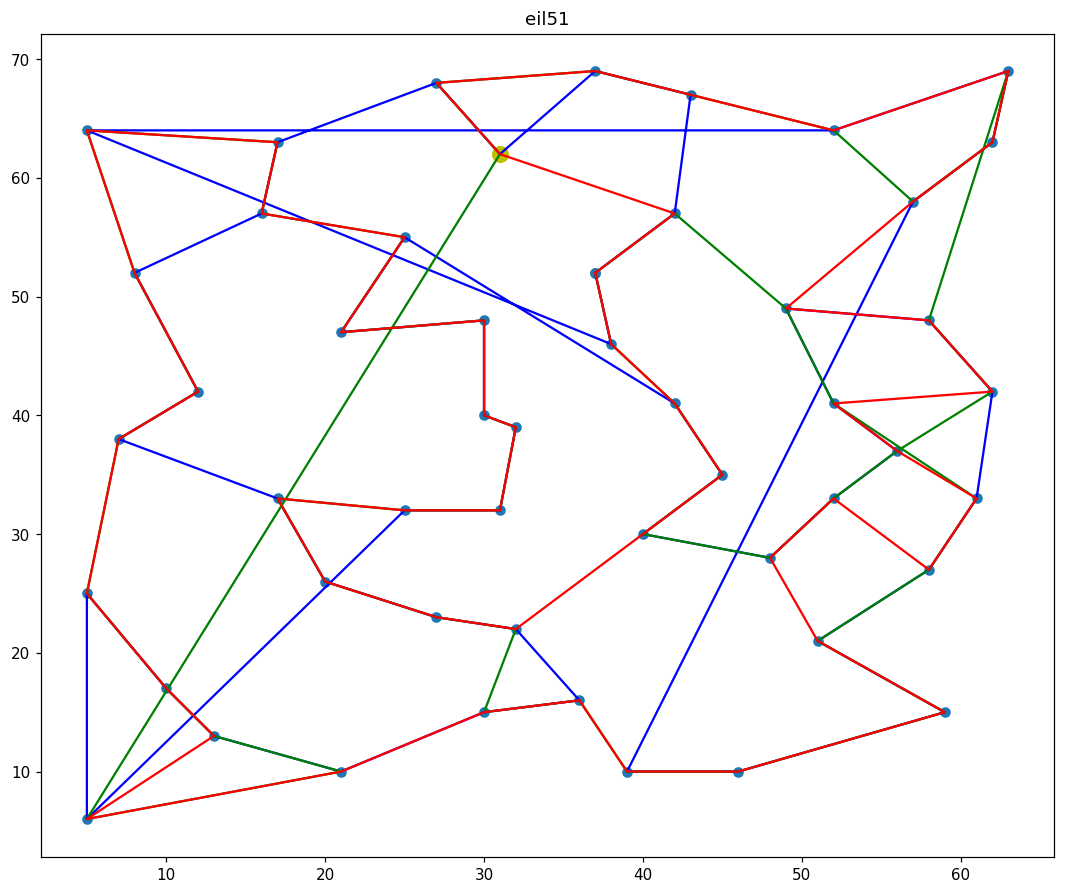

(red)   Optimal  Tour:    426   100.0%
(grn) Minimum NN Tour:    482   113.15%   (ylw) Start Node
(blu) Maximum NN Tour:    563   132.16%

  Average Tour Length:    526   123.47%

  1 tours of length    482:	[8]
  1 tours of length    483:	[24]
  2 tours of length    485:	[23, 26]
  4 tours of length    495:	[19, 25, 40, 42]
  1 tours of length    496:	[31]
  1 tours of length    503:	[47]
  1 tours of length    505:	[37]
  3 tours of length    507:	[6, 41, 48]
  1 tours of length    508:	[13]
  2 tours of length    509:	[27, 44]
  1 tours of length    511:	[1]
  3 tours of length    512:	[7, 14, 43]
  1 tours of length    515:	[15]
  1 tours of length    518:	[22]
  1 tours of length    523:	[45]
  1 tours of length    529:	[2]
  2 tours of length    530:	[18, 38]
  1 tours of length    531:	[4]
  1 tours of length    534:	[17]
  1 tours of length    536:	[33]
  2 tours of length    541:	[9, 39]
  1 tours of length    542:	[21]
  1 tours of length    543:	[29]
  3 tours of length    5

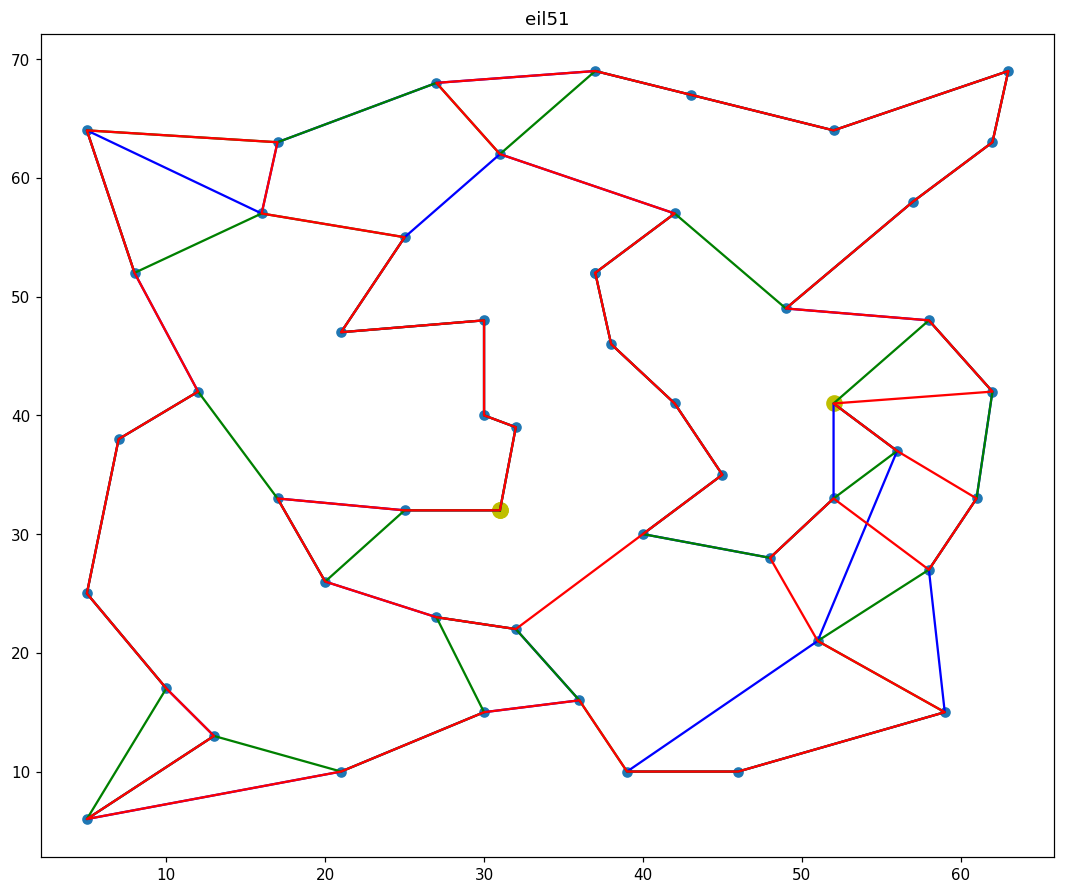

(red)   Optimal  Tour:    426   100.0%
(grn) Minimum NN Tour:    428   100.47%   (ylw) Start Node
(blu) Maximum NN Tour:    448   105.16%

  Average Tour Length:    436   102.35%


                        Min      Max      Ave

Perturbation loops:       3        5        4
         Effective:      13       35       23
       Ineffective:    3643     6106     4781

          Reversal:       3       15        9
       Rotate Left:       3       13        7
      Rotate Right:       1       11        5
          Exchange:       0        7        2
         Multiples:       1       12        5


  2 tours of length    428:	[12, 16]
  4 tours of length    430:	[1, 8, 25, 27]
  1 tours of length    431:	[2]
  4 tours of length    432:	[22, 23, 24, 31]
  2 tours of length    433:	[38, 47]
  1 tours of length    434:	[3]
 14 tours of length    435:	[6, 13, 15, 18, 19, 26, 33, 37, 40, 41, 42, 45, 46, 49]
  2 tours of length    436:	[11, 35]
  7 tours of length    437:	[7, 14, 28, 29, 43, 44, 51

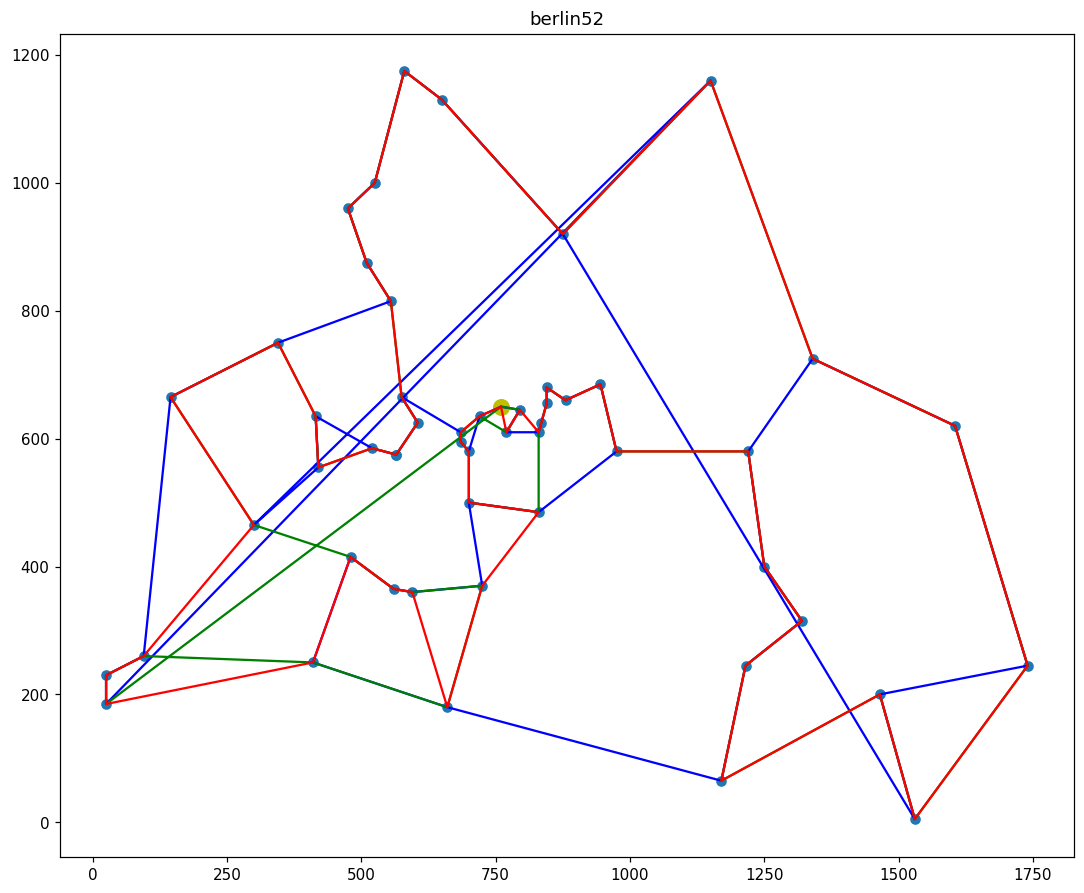

(red)   Optimal  Tour:   7542   100.0%
(grn) Minimum NN Tour:   8181   108.47%   (ylw) Start Node
(blu) Maximum NN Tour:  10298   136.54%

  Average Tour Length:   9376   124.32%

  1 tours of length   8181:	[40]
  1 tours of length   8206:	[38]
  1 tours of length   8848:	[23]
  2 tours of length   8864:	[30, 42]
  1 tours of length   8920:	[22]
  1 tours of length   8953:	[31]
  1 tours of length   8980:	[1]
  1 tours of length   8995:	[18]
  1 tours of length   9013:	[37]
  1 tours of length   9067:	[48]
  1 tours of length   9073:	[44]
  1 tours of length   9091:	[32]
  1 tours of length   9098:	[24]
  1 tours of length   9112:	[10]
  1 tours of length   9123:	[49]
  1 tours of length   9137:	[34]
  1 tours of length   9156:	[36]
  1 tours of length   9161:	[35]
  1 tours of length   9192:	[9]
  1 tours of length   9214:	[39]
  1 tours of length   9220:	[19]
  1 tours of length   9251:	[50]
  1 tours of length   9252:	[20]
  1 tours of length   9257:	[46]
  1 tours of length   9290

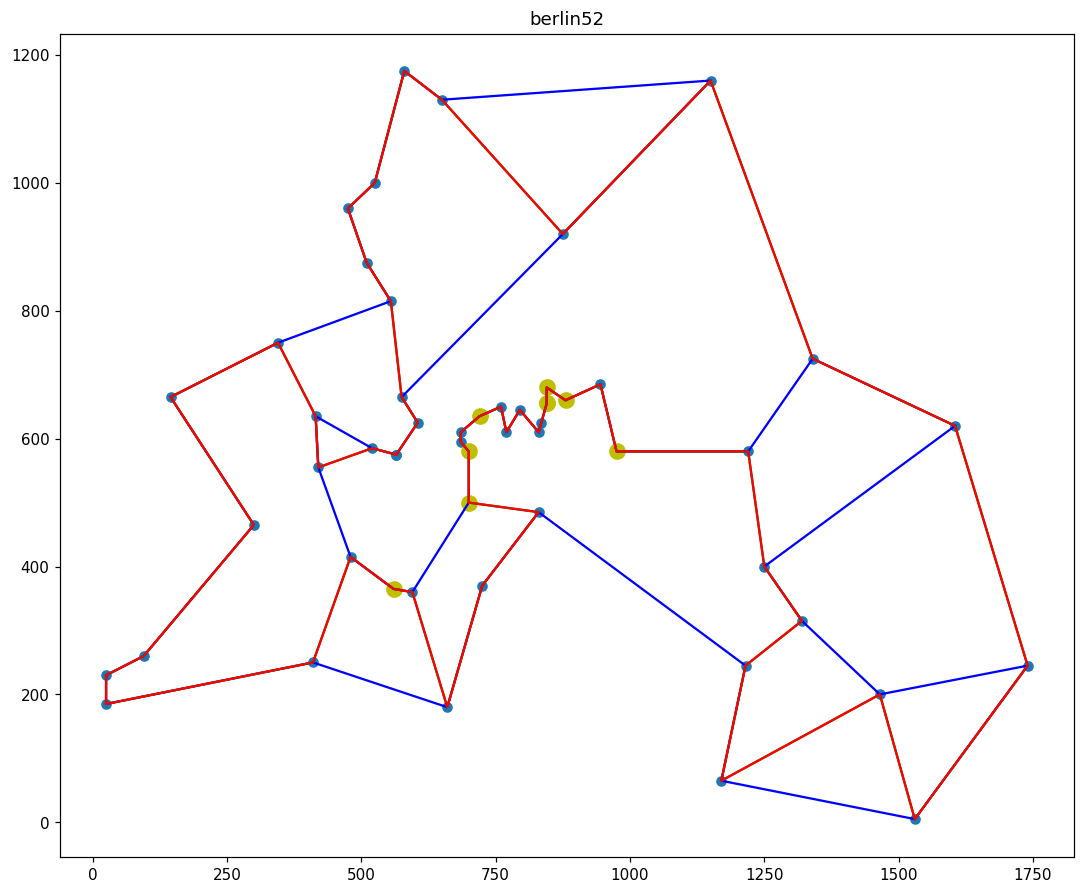

(red)   Optimal  Tour:   7542   100.0%
(grn) Minimum NN Tour:   7542   100.0%   (ylw) Start Node
(blu) Maximum NN Tour:   8338   110.55%

  Average Tour Length:   7869   104.34%


                        Min      Max      Ave

Perturbation loops:       3        6        4
         Effective:      13       40       26
       Ineffective:    3790     7619     4976

          Reversal:       5       21       13
       Rotate Left:       0       16        6
      Rotate Right:       0       13        5
          Exchange:       0        7        3
         Multiples:       2       15        7


  8 tours of length   7542:	[5, 6, 15, 20, 25, 34, 39, 44]
  1 tours of length   7715:	[16]
  2 tours of length   7741:	[38, 40]
  1 tours of length   7746:	[18]
  5 tours of length   7749:	[1, 22, 29, 31, 50]
  1 tours of length   7806:	[35]
  2 tours of length   7810:	[24, 48]
  1 tours of length   7827:	[37]
  2 tours of length   7840:	[32, 49]
  1 tours of length   7848:	[36]
  1 tours of length

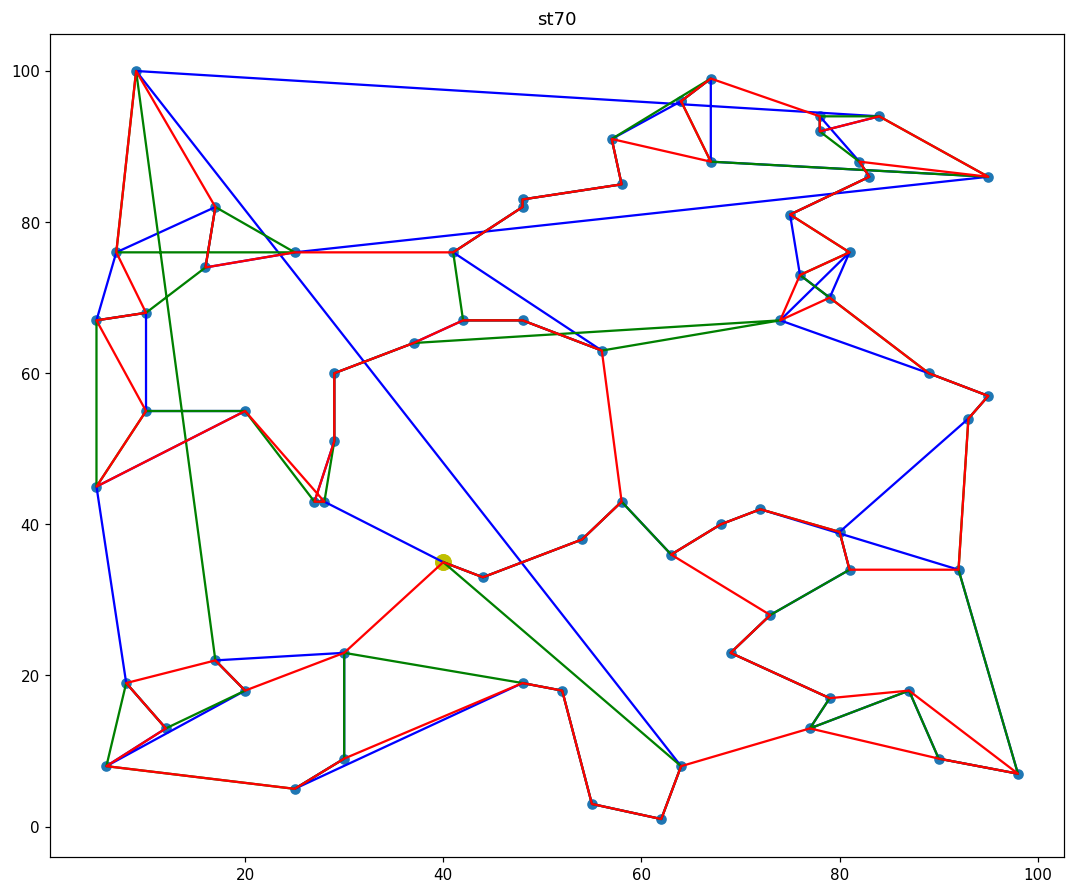

(red)   Optimal  Tour:    675   100.0%
(grn) Minimum NN Tour:    796   117.93%   (ylw) Start Node
(blu) Maximum NN Tour:    911   134.96%

  Average Tour Length:    841   124.59%

  1 tours of length    796:	[17]
  2 tours of length    803:	[21, 34]
  1 tours of length    808:	[41]
  1 tours of length    809:	[60]
  1 tours of length    810:	[27]
  2 tours of length    811:	[11, 48]
  1 tours of length    812:	[40]
  2 tours of length    814:	[6, 46]
  3 tours of length    815:	[9, 64, 65]
  2 tours of length    819:	[52, 61]
  1 tours of length    820:	[67]
  1 tours of length    821:	[4]
  1 tours of length    823:	[43]
  2 tours of length    825:	[12, 39]
  1 tours of length    826:	[25]
  1 tours of length    827:	[5]
  1 tours of length    828:	[62]
  1 tours of length    829:	[30]
  2 tours of length    830:	[1, 68]
  2 tours of length    831:	[28, 53]
  3 tours of length    832:	[19, 50, 51]
  1 tours of length    833:	[8]
  1 tours of length    835:	[37]
  1 tours of length    

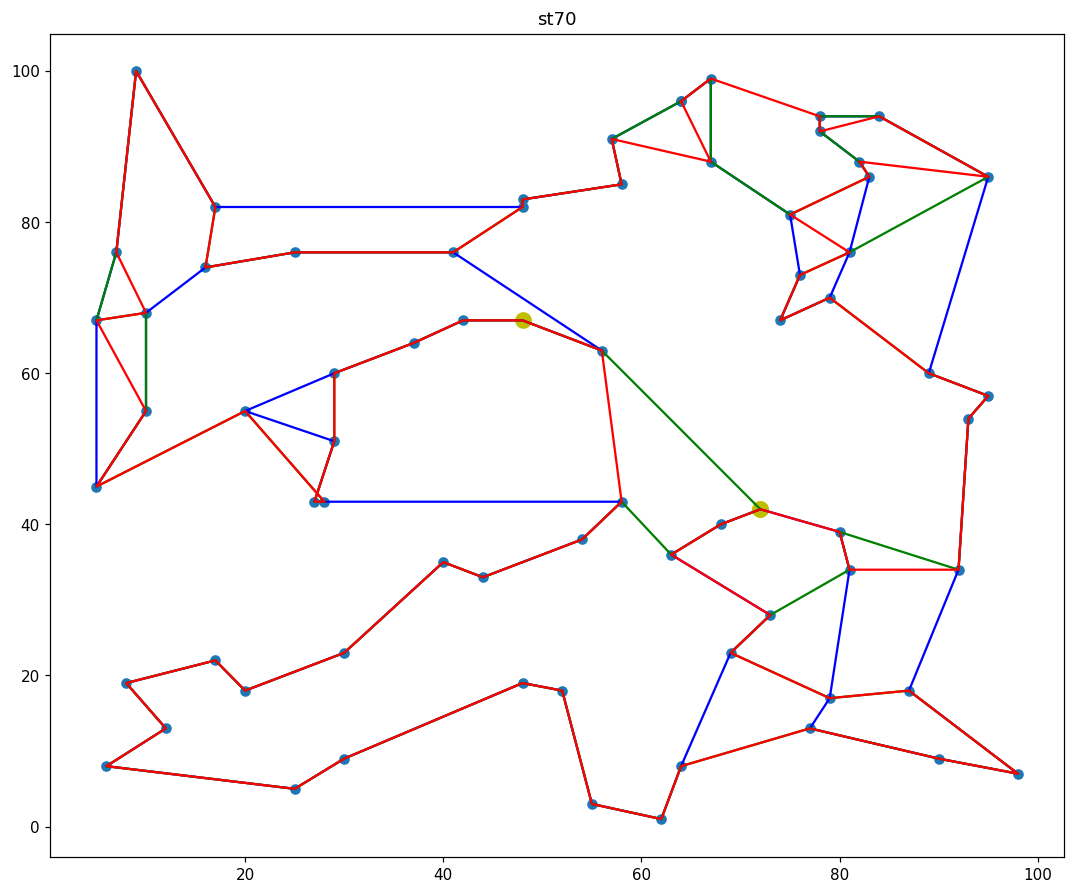

(red)   Optimal  Tour:    675   100.0%
(grn) Minimum NN Tour:    682   101.04%   (ylw) Start Node
(blu) Maximum NN Tour:    739   109.48%

  Average Tour Length:    700   103.7%


                        Min      Max      Ave

Perturbation loops:       3        6        4
         Effective:      16       49       29
       Ineffective:    6994    14048     9154

          Reversal:       7       23       13
       Rotate Left:       1       15        8
      Rotate Right:       2       13        6
          Exchange:       0        7        3
         Multiples:       2       13        7


  2 tours of length    682:	[4, 5]
  4 tours of length    683:	[29, 31, 32, 69]
  2 tours of length    685:	[6, 41]
  6 tours of length    686:	[12, 21, 27, 34, 46, 54]
  6 tours of length    687:	[13, 22, 35, 40, 61, 63]
  1 tours of length    688:	[10]
  3 tours of length    689:	[15, 24, 37]
  2 tours of length    690:	[14, 20]
  2 tours of length    691:	[3, 70]
  1 tours of length    692:	[50]


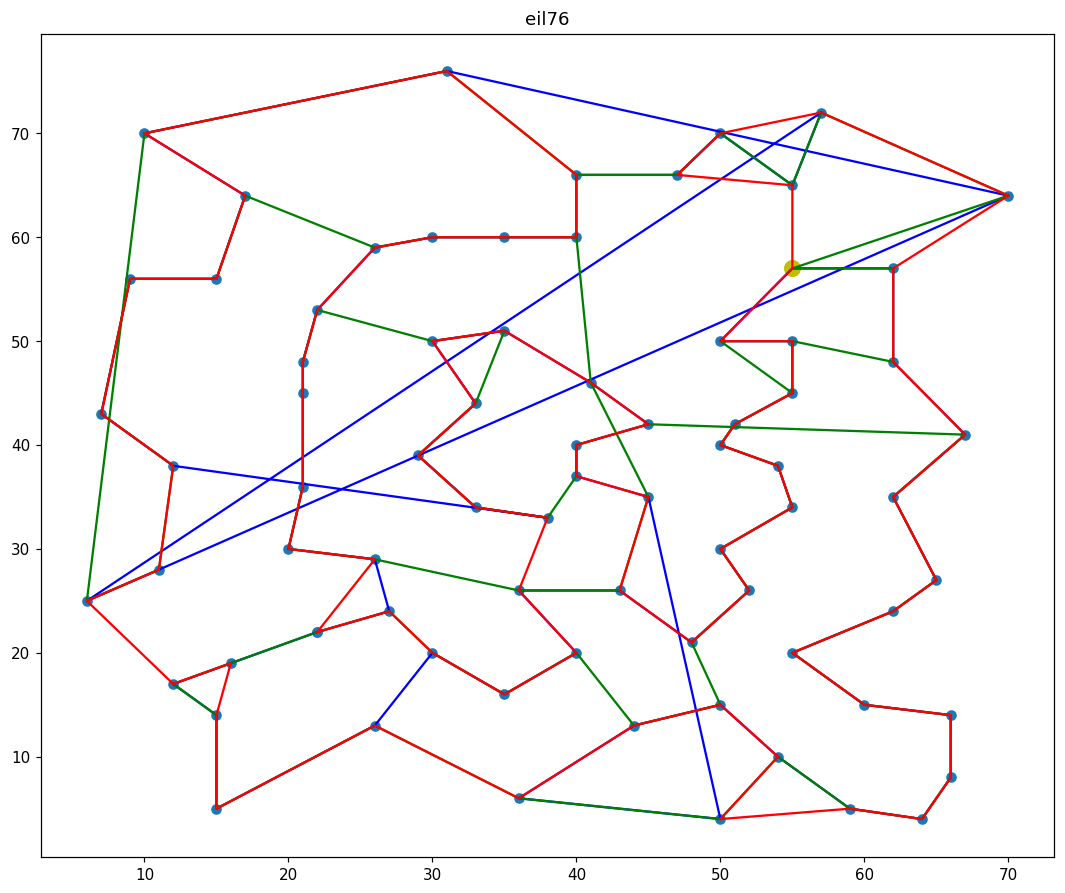

(red)   Optimal  Tour:    538   100.0%
(grn) Minimum NN Tour:    608   113.01%   (ylw) Start Node
(blu) Maximum NN Tour:    710   131.97%

  Average Tour Length:    666   123.79%

  1 tours of length    608:	[53]
  1 tours of length    612:	[52]
  1 tours of length    614:	[46]
  1 tours of length    618:	[33]
  3 tours of length    630:	[24, 67, 76]
  1 tours of length    631:	[34]
  1 tours of length    632:	[45]
  1 tours of length    634:	[17]
  1 tours of length    636:	[75]
  2 tours of length    637:	[4, 38]
  1 tours of length    639:	[42]
  1 tours of length    640:	[64]
  1 tours of length    641:	[68]
  3 tours of length    642:	[1, 6, 41]
  1 tours of length    646:	[51]
  1 tours of length    647:	[40]
  1 tours of length    648:	[63]
  1 tours of length    650:	[28]
  2 tours of length    651:	[12, 16]
  1 tours of length    654:	[23]
  1 tours of length    655:	[74]
  2 tours of length    656:	[25, 26]
  1 tours of length    657:	[55]
  1 tours of length    659:	[3]
  2 

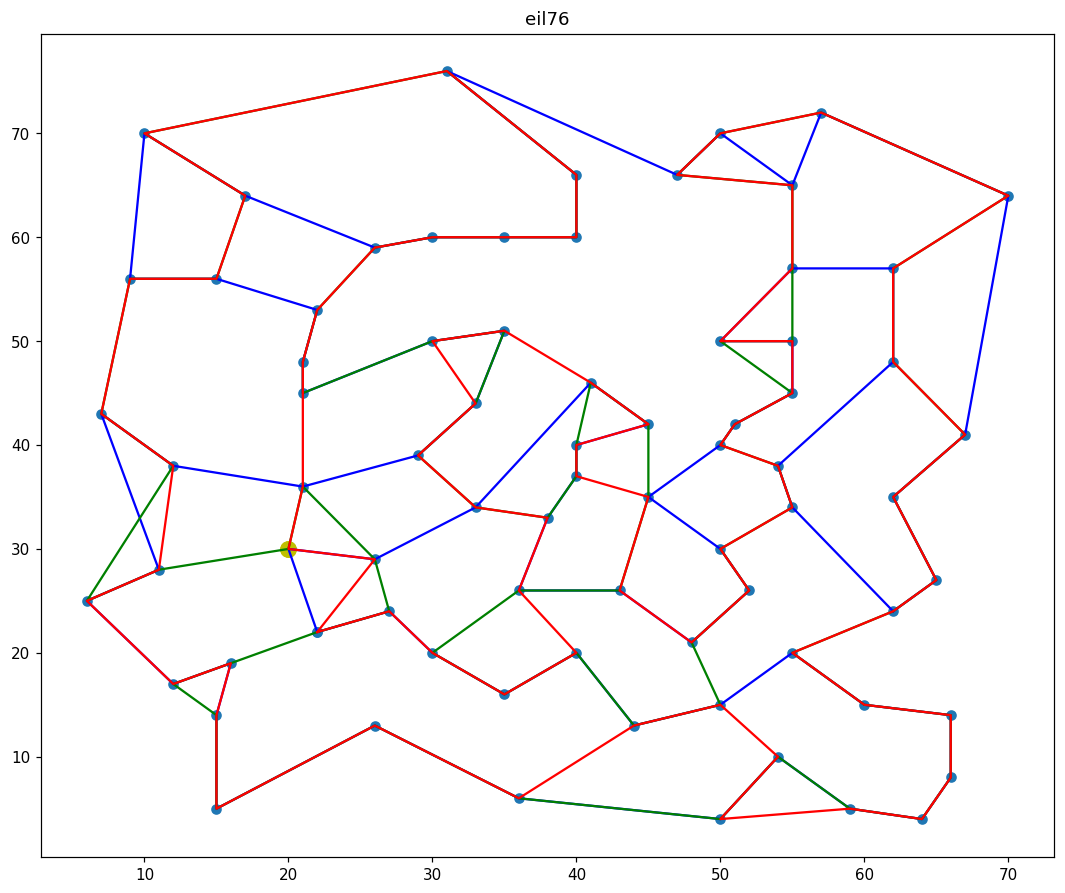

(red)   Optimal  Tour:    538   100.0%
(grn) Minimum NN Tour:    545   101.3%   (ylw) Start Node
(blu) Maximum NN Tour:    584   108.55%

  Average Tour Length:    560   104.09%


                        Min      Max      Ave

Perturbation loops:       3        7        4
         Effective:      13       47       29
       Ineffective:    8287    19392    10597

          Reversal:       5       27       13
       Rotate Left:       2       17        7
      Rotate Right:       0       13        6
          Exchange:       0        8        2
         Multiples:       1       15        6


  1 tours of length    545:	[63]
  2 tours of length    547:	[39, 59]
  2 tours of length    548:	[1, 43]
  1 tours of length    549:	[65]
  1 tours of length    550:	[17]
  1 tours of length    551:	[32]
  1 tours of length    552:	[6]
  4 tours of length    553:	[24, 51, 55, 64]
  3 tours of length    554:	[7, 28, 76]
  2 tours of length    556:	[25, 37]
  9 tours of length    557:	[3, 9, 13, 16, 

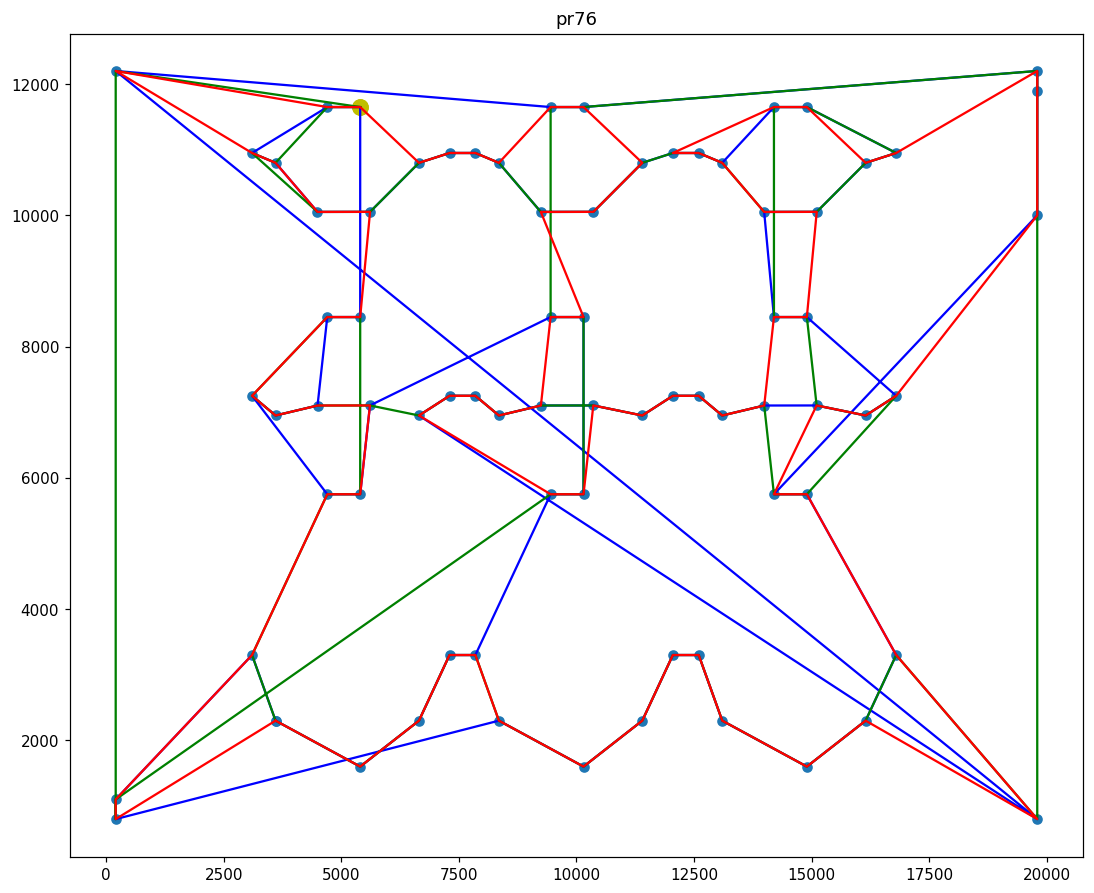

(red)   Optimal  Tour:  108159   100.0%
(grn) Minimum NN Tour:  130921   121.04%   (ylw) Start Node
(blu) Maximum NN Tour:  157073   145.22%

  Average Tour Length:  147178   136.08%

  1 tours of length  130921:	[16]
  1 tours of length  131607:	[11]
  1 tours of length  132174:	[15]
  1 tours of length  133895:	[12]
  1 tours of length  134394:	[32]
  1 tours of length  134686:	[43]
  1 tours of length  135240:	[74]
  1 tours of length  135401:	[14]
  1 tours of length  135900:	[13]
  1 tours of length  137132:	[30]
  1 tours of length  137933:	[33]
  1 tours of length  138644:	[36]
  1 tours of length  139635:	[37]
  1 tours of length  140474:	[38]
  1 tours of length  141100:	[29]
  1 tours of length  141588:	[27]
  1 tours of length  142172:	[26]
  1 tours of length  142392:	[10]
  1 tours of length  142460:	[35]
  1 tours of length  142610:	[31]
  1 tours of length  142881:	[42]
  1 tours of length  143096:	[4]
  1 tours of length  143812:	[39]
  1 tours of length  145678:	[40]
 

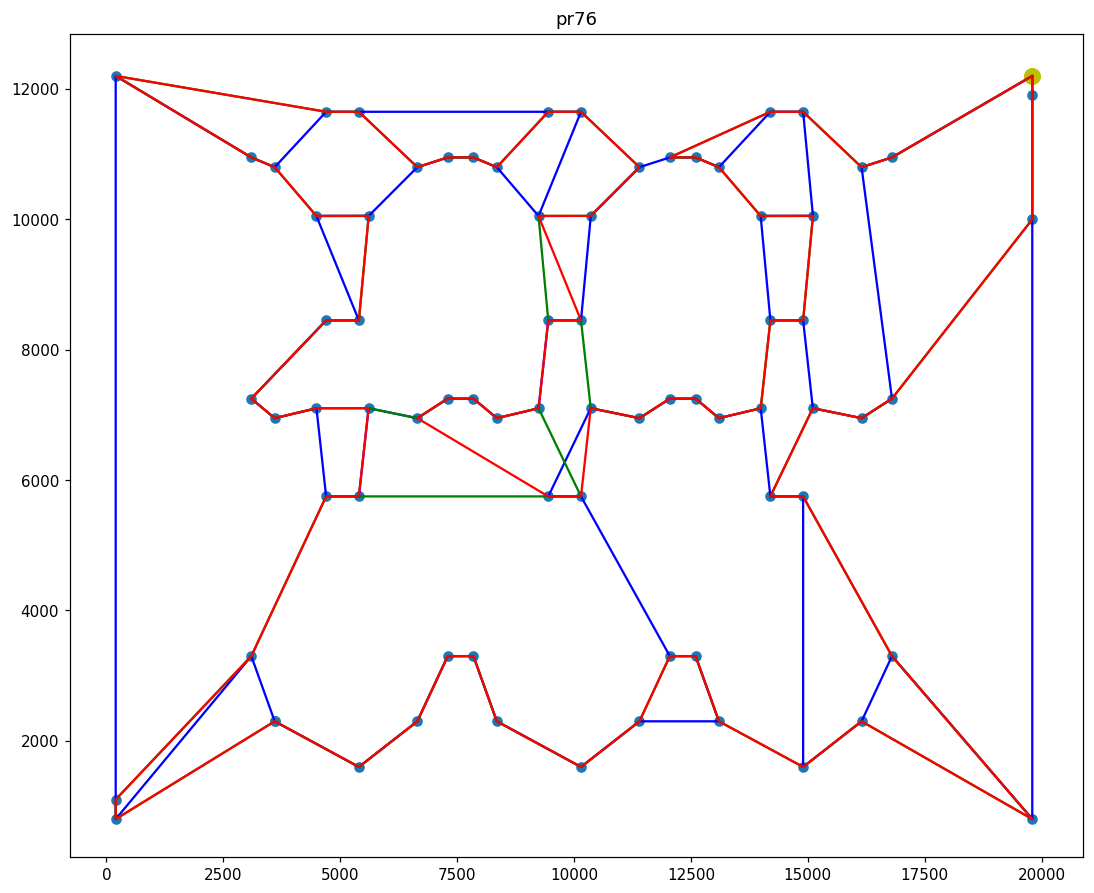

(red)   Optimal  Tour:  108159   100.0%
(grn) Minimum NN Tour:  108879   100.67%   (ylw) Start Node
(blu) Maximum NN Tour:  118116   109.21%

  Average Tour Length:  112741   104.24%


                        Min      Max      Ave

Perturbation loops:       2        7        4
         Effective:      23       72       48
       Ineffective:    5527    19380    11453

          Reversal:      12       38       23
       Rotate Left:       1       20       11
      Rotate Right:       2       18       10
          Exchange:       0       12        5
         Multiples:       2       27       14


  1 tours of length  108879:	[73]
  1 tours of length  109392:	[22]
  5 tours of length  109827:	[2, 23, 69, 75, 76]
  1 tours of length  109836:	[16]
  1 tours of length  110011:	[47]
  1 tours of length  110173:	[27]
  1 tours of length  110285:	[65]
  1 tours of length  110606:	[33]
  1 tours of length  110674:	[8]
  4 tours of length  110988:	[41, 58, 63, 64]
  1 tours of length  110997:	[5

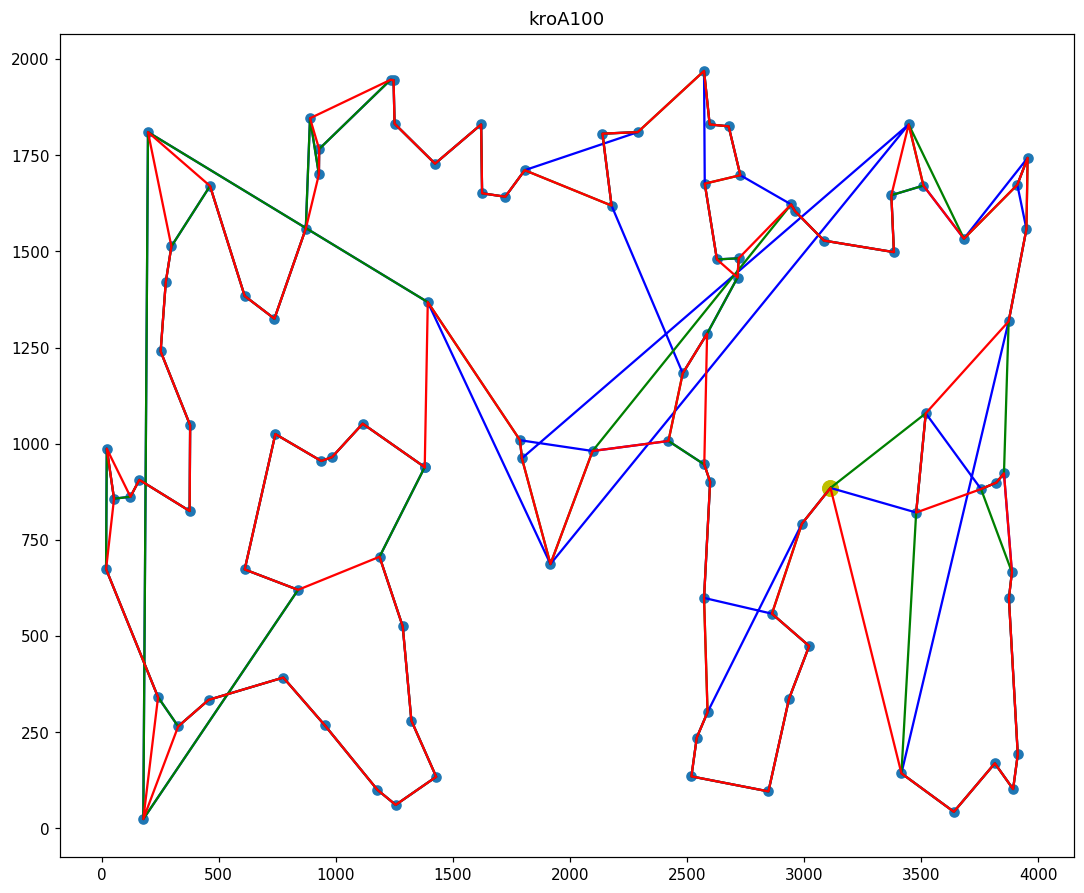

(red)   Optimal  Tour:  21282   100.0%
(grn) Minimum NN Tour:  24698   116.05%   (ylw) Start Node
(blu) Maximum NN Tour:  28692   134.82%

  Average Tour Length:  27046   127.08%

  1 tours of length  24698:	[85]
  1 tours of length  25420:	[50]
  1 tours of length  25525:	[44]
  1 tours of length  25647:	[30]
  1 tours of length  25760:	[68]
  1 tours of length  25778:	[58]
  1 tours of length  25878:	[39]
  1 tours of length  25943:	[51]
  1 tours of length  26131:	[54]
  1 tours of length  26133:	[2]
  1 tours of length  26155:	[64]
  1 tours of length  26207:	[81]
  1 tours of length  26224:	[41]
  1 tours of length  26233:	[25]
  1 tours of length  26259:	[66]
  1 tours of length  26263:	[71]
  2 tours of length  26288:	[26, 65]
  1 tours of length  26309:	[40]
  1 tours of length  26326:	[73]
  1 tours of length  26355:	[20]
  1 tours of length  26427:	[94]
  1 tours of length  26432:	[48]
  1 tours of length  26462:	[97]
  1 tours of length  26466:	[34]
  2 tours of length  2647

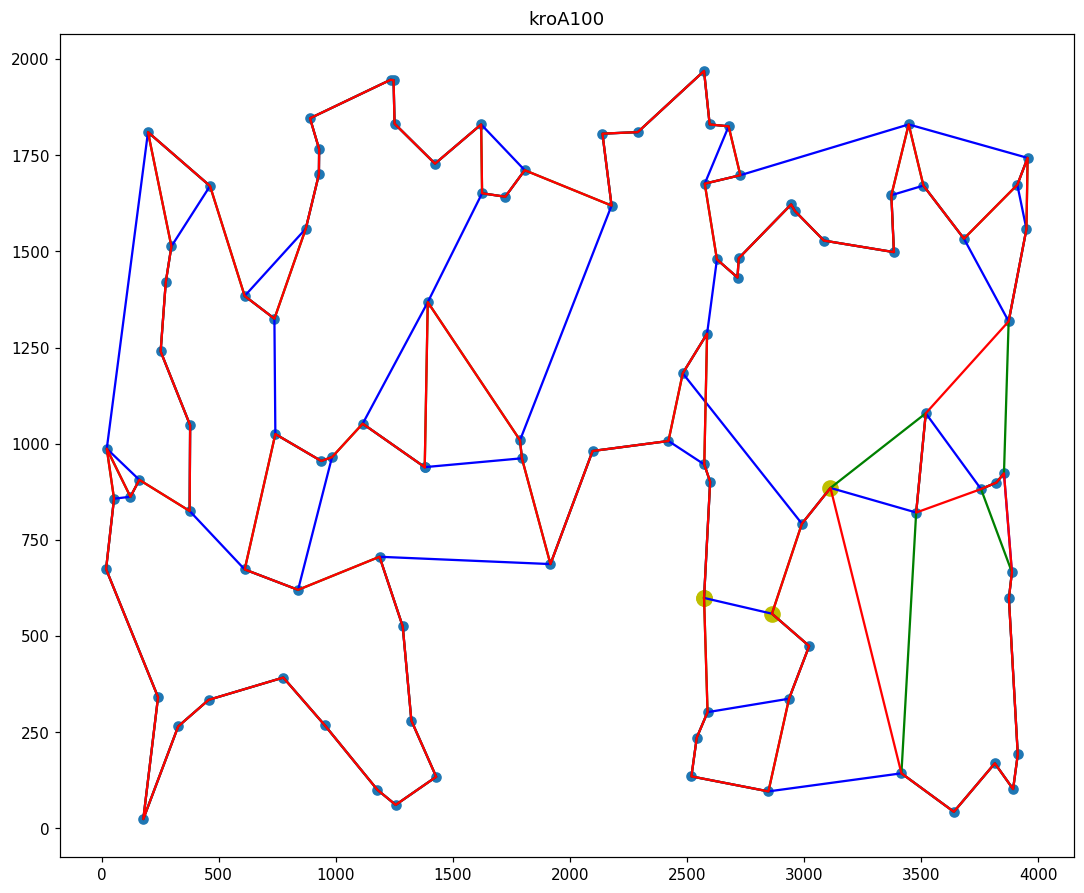

(red)   Optimal  Tour:  21282   100.0%
(grn) Minimum NN Tour:  21292   100.05%   (ylw) Start Node
(blu) Maximum NN Tour:  23436   110.12%

  Average Tour Length:  21971   103.24%


                        Min      Max      Ave

Perturbation loops:       3        6        4
         Effective:      35       64       50
       Ineffective:   14495    29055    20324

          Reversal:      13       35       23
       Rotate Left:       4       21       11
      Rotate Right:       4       22       12
          Exchange:       1       11        4
         Multiples:       3       22       12


  3 tours of length  21292:	[69, 73, 85]
  1 tours of length  21320:	[39]
  2 tours of length  21411:	[38, 92]
  2 tours of length  21434:	[19, 36]
  4 tours of length  21479:	[15, 24, 68, 72]
  1 tours of length  21481:	[51]
  1 tours of length  21482:	[22]
  1 tours of length  21498:	[90]
  1 tours of length  21528:	[35]
  1 tours of length  21566:	[4]
  1 tours of length  21570:	[18]
  3 tours o

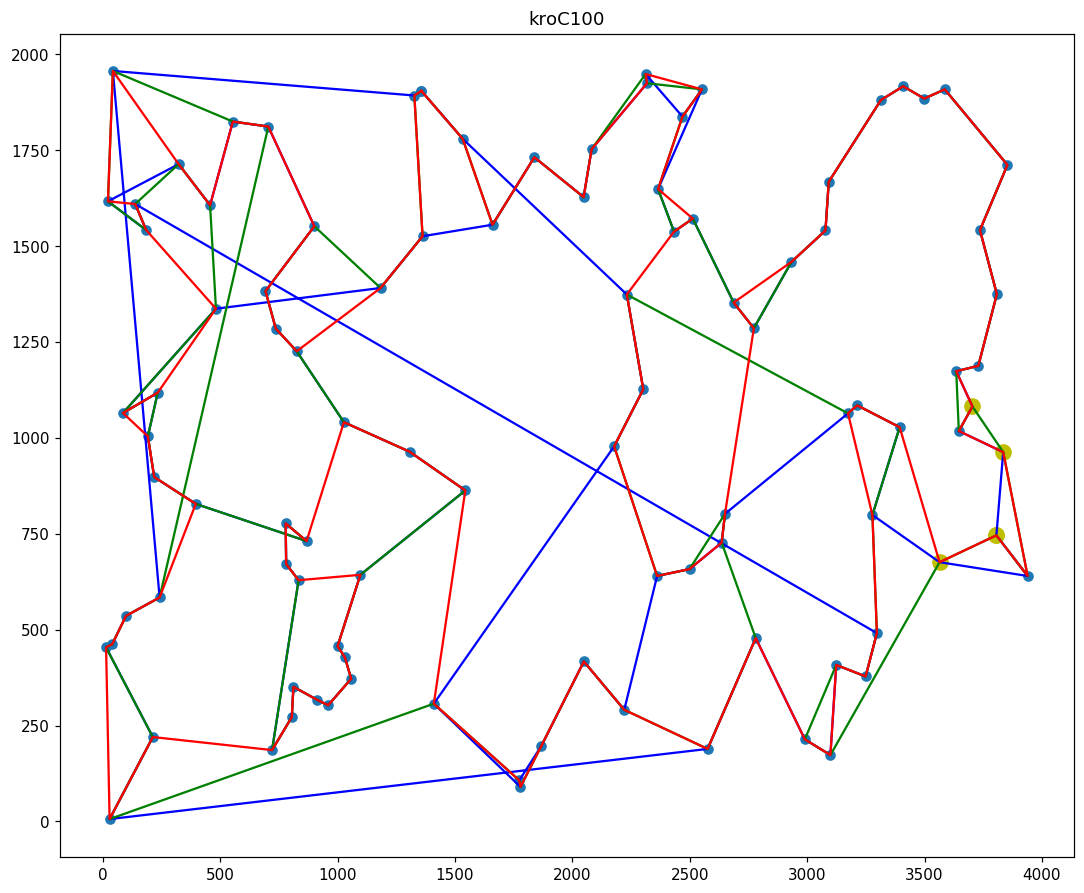

(red)   Optimal  Tour:  20749   100.0%
(grn) Minimum NN Tour:  23660   114.03%   (ylw) Start Node
(blu) Maximum NN Tour:  29488   142.12%

  Average Tour Length:  26181   126.18%

  4 tours of length  23660:	[5, 38, 56, 86]
  1 tours of length  23665:	[43]
  1 tours of length  23695:	[71]
  1 tours of length  24247:	[47]
  1 tours of length  24268:	[77]
  1 tours of length  24286:	[31]
  1 tours of length  24362:	[83]
  1 tours of length  24364:	[62]
  1 tours of length  24432:	[67]
  1 tours of length  24546:	[88]
  1 tours of length  24551:	[42]
  1 tours of length  24572:	[55]
  1 tours of length  24779:	[13]
  1 tours of length  24852:	[79]
  1 tours of length  24891:	[75]
  1 tours of length  24901:	[10]
  1 tours of length  24954:	[33]
  1 tours of length  25060:	[99]
  1 tours of length  25064:	[92]
  2 tours of length  25108:	[48, 97]
  2 tours of length  25140:	[51, 63]
  1 tours of length  25157:	[19]
  1 tours of length  25194:	[60]
  1 tours of length  25259:	[16]
  1 tours

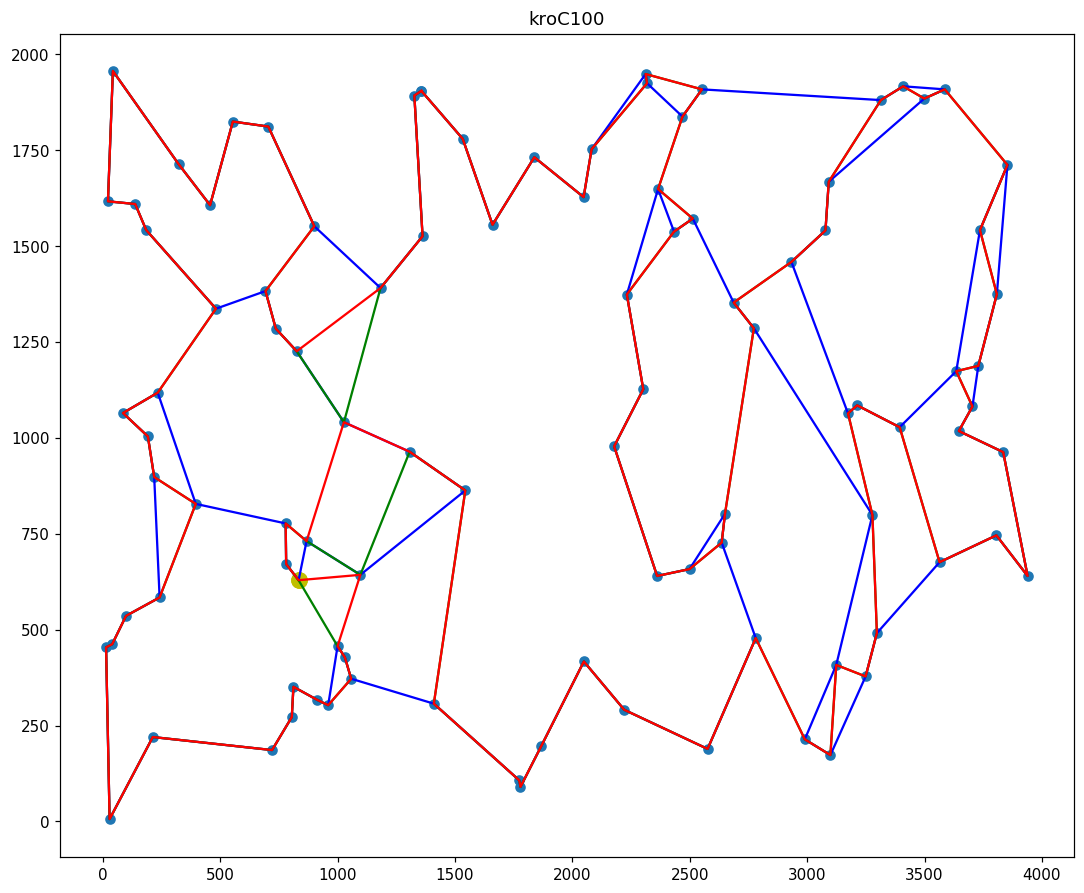

(red)   Optimal  Tour:  20749   100.0%
(grn) Minimum NN Tour:  20769   100.1%   (ylw) Start Node
(blu) Maximum NN Tour:  22570   108.78%

  Average Tour Length:  21581   104.01%


                        Min      Max      Ave

Perturbation loops:       3        7        4
         Effective:      31       70       48
       Ineffective:   14490    33911    20618

          Reversal:      16       39       25
       Rotate Left:       2       19        9
      Rotate Right:       3       17        9
          Exchange:       1       11        4
         Multiples:       7       22       12


  1 tours of length  20769:	[10]
  6 tours of length  20880:	[13, 31, 32, 47, 67, 79]
  1 tours of length  20983:	[6]
  2 tours of length  21022:	[87, 96]
  3 tours of length  21064:	[59, 70, 80]
  1 tours of length  21127:	[39]
  1 tours of length  21163:	[91]
  1 tours of length  21195:	[33]
  1 tours of length  21232:	[28]
  1 tours of length  21242:	[24]
  4 tours of length  21247:	[8, 22, 42, 5

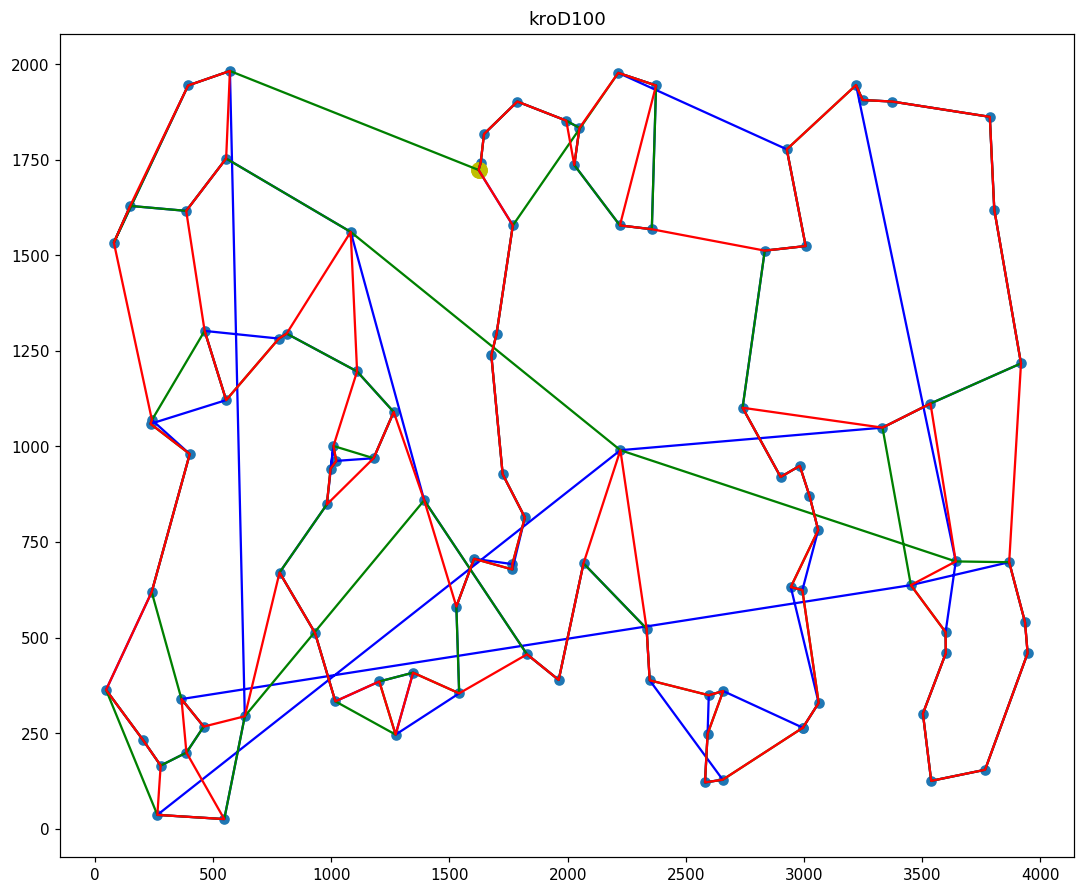

(red)   Optimal  Tour:  21294   100.0%
(grn) Minimum NN Tour:  24852   116.71%   (ylw) Start Node
(blu) Maximum NN Tour:  29921   140.51%

  Average Tour Length:  27469   129.0%

  1 tours of length  24852:	[14]
  1 tours of length  24878:	[68]
  1 tours of length  25026:	[99]
  1 tours of length  25039:	[45]
  1 tours of length  25105:	[31]
  1 tours of length  25123:	[78]
  1 tours of length  25137:	[33]
  1 tours of length  25248:	[84]
  1 tours of length  25300:	[41]
  1 tours of length  25407:	[86]
  1 tours of length  25707:	[77]
  1 tours of length  25715:	[80]
  1 tours of length  25728:	[76]
  1 tours of length  26382:	[81]
  1 tours of length  26390:	[8]
  1 tours of length  26397:	[66]
  1 tours of length  26414:	[52]
  1 tours of length  26447:	[34]
  1 tours of length  26457:	[11]
  1 tours of length  26507:	[23]
  1 tours of length  26535:	[38]
  1 tours of length  26561:	[69]
  1 tours of length  26583:	[24]
  1 tours of length  26595:	[27]
  1 tours of length  26679:	[4

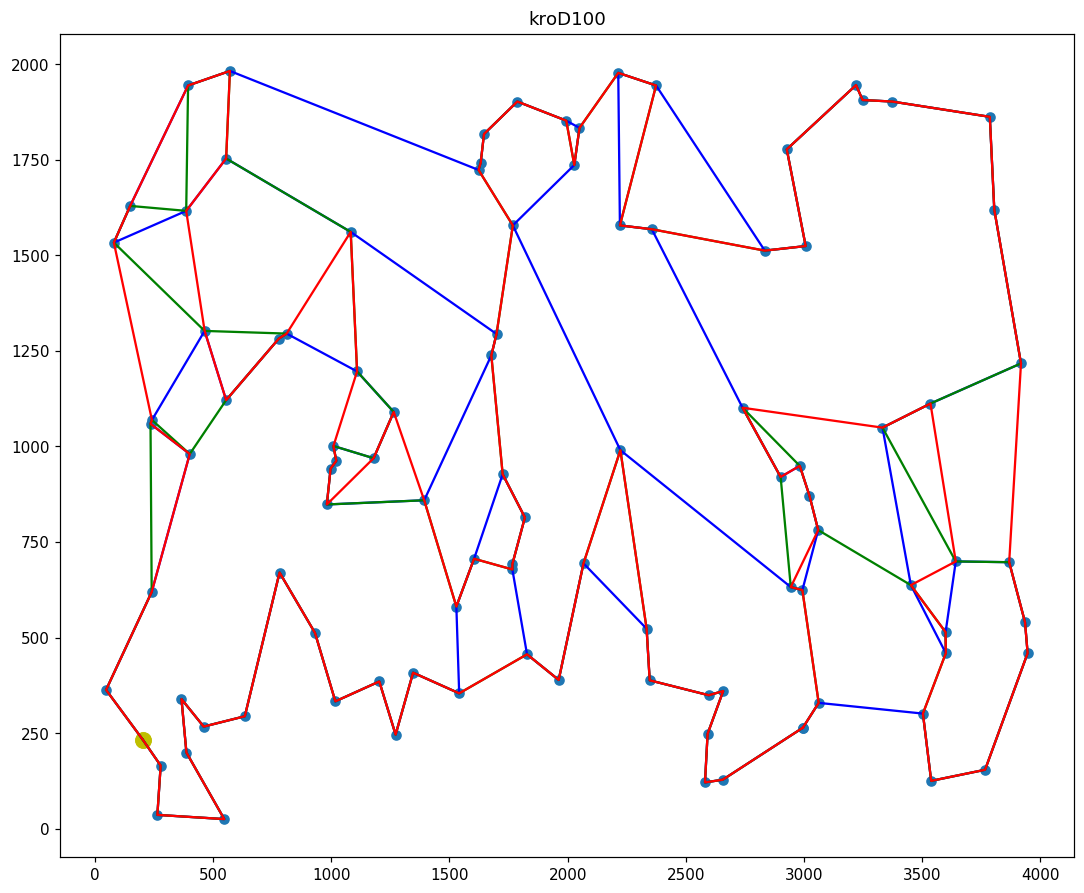

(red)   Optimal  Tour:  21294   100.0%
(grn) Minimum NN Tour:  21578   101.33%   (ylw) Start Node
(blu) Maximum NN Tour:  23728   111.43%

  Average Tour Length:  22593   106.1%


                        Min      Max      Ave

Perturbation loops:       3        6        4
         Effective:      23       84       51
       Ineffective:   14503    29058    20566

          Reversal:      13       40       28
       Rotate Left:       3       16        8
      Rotate Right:       3       26       10
          Exchange:       0       11        4
         Multiples:       5       29       14


  1 tours of length  21578:	[2]
  2 tours of length  21614:	[48, 100]
  2 tours of length  21616:	[83, 85]
  1 tours of length  21665:	[43]
  1 tours of length  21675:	[35]
  1 tours of length  21696:	[77]
  1 tours of length  21716:	[3]
  1 tours of length  21806:	[39]
  1 tours of length  21842:	[72]
  1 tours of length  21891:	[40]
  5 tours of length  21901:	[49, 89, 90, 97, 98]
  1 tours of len

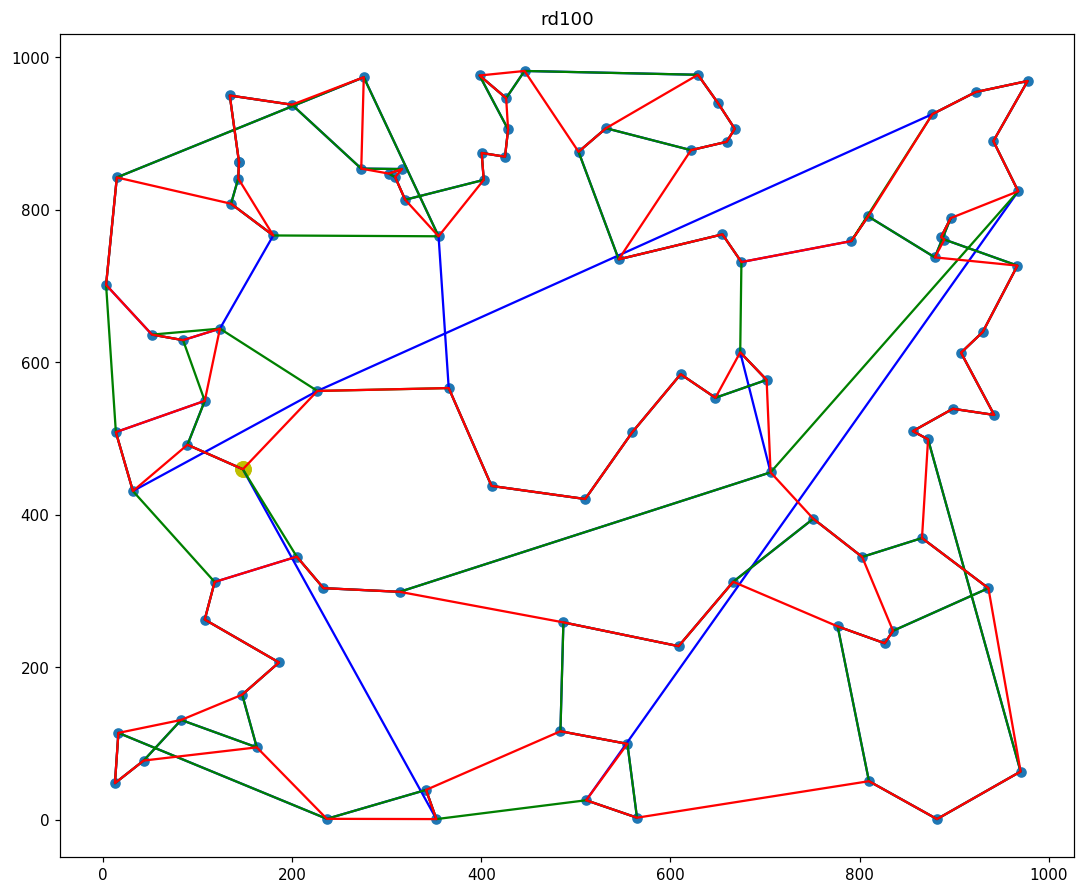

(red)   Optimal  Tour:   7910   100.0%
(grn) Minimum NN Tour:   9423   119.13%   (ylw) Start Node
(blu) Maximum NN Tour:  10772   136.18%

  Average Tour Length:  10110   127.81%

  1 tours of length   9423:	[81]
  1 tours of length   9502:	[36]
  1 tours of length   9515:	[90]
  1 tours of length   9548:	[78]
  2 tours of length   9587:	[20, 64]
  1 tours of length   9598:	[74]
  1 tours of length   9618:	[9]
  1 tours of length   9669:	[45]
  1 tours of length   9707:	[13]
  1 tours of length   9727:	[65]
  1 tours of length   9769:	[7]
  1 tours of length   9776:	[94]
  1 tours of length   9799:	[32]
  1 tours of length   9842:	[40]
  1 tours of length   9847:	[44]
  2 tours of length   9850:	[57, 67]
  1 tours of length   9857:	[49]
  1 tours of length   9858:	[100]
  1 tours of length   9861:	[21]
  1 tours of length   9868:	[4]
  1 tours of length   9879:	[39]
  1 tours of length   9884:	[43]
  1 tours of length   9889:	[42]
  1 tours of length   9893:	[6]
  1 tours of length   9

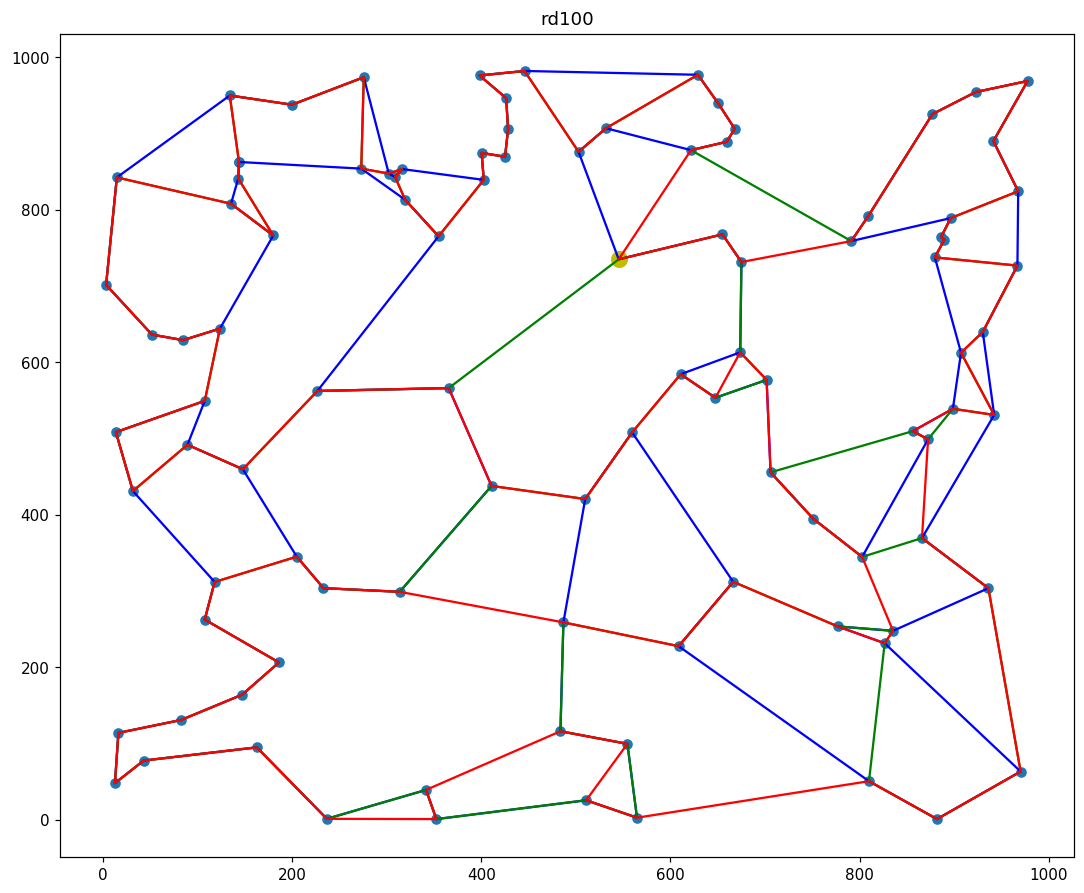

(red)   Optimal  Tour:   7910   100.0%
(grn) Minimum NN Tour:   8006   101.21%   (ylw) Start Node
(blu) Maximum NN Tour:   8815   111.44%

  Average Tour Length:   8305   104.99%


                        Min      Max      Ave

Perturbation loops:       3        7        4
         Effective:      29       72       48
       Ineffective:   14489    33907    19405

          Reversal:      14       38       23
       Rotate Left:       4       19       10
      Rotate Right:       2       19        8
          Exchange:       1       13        6
         Multiples:       6       25       14


  1 tours of length   8006:	[3]
  1 tours of length   8012:	[90]
  1 tours of length   8055:	[91]
  1 tours of length   8056:	[53]
  1 tours of length   8072:	[77]
  1 tours of length   8075:	[21]
  1 tours of length   8082:	[63]
  1 tours of length   8094:	[68]
  1 tours of length   8099:	[62]
  5 tours of length   8102:	[20, 26, 74, 78, 82]
  3 tours of length   8106:	[14, 49, 85]
  3 tours of le

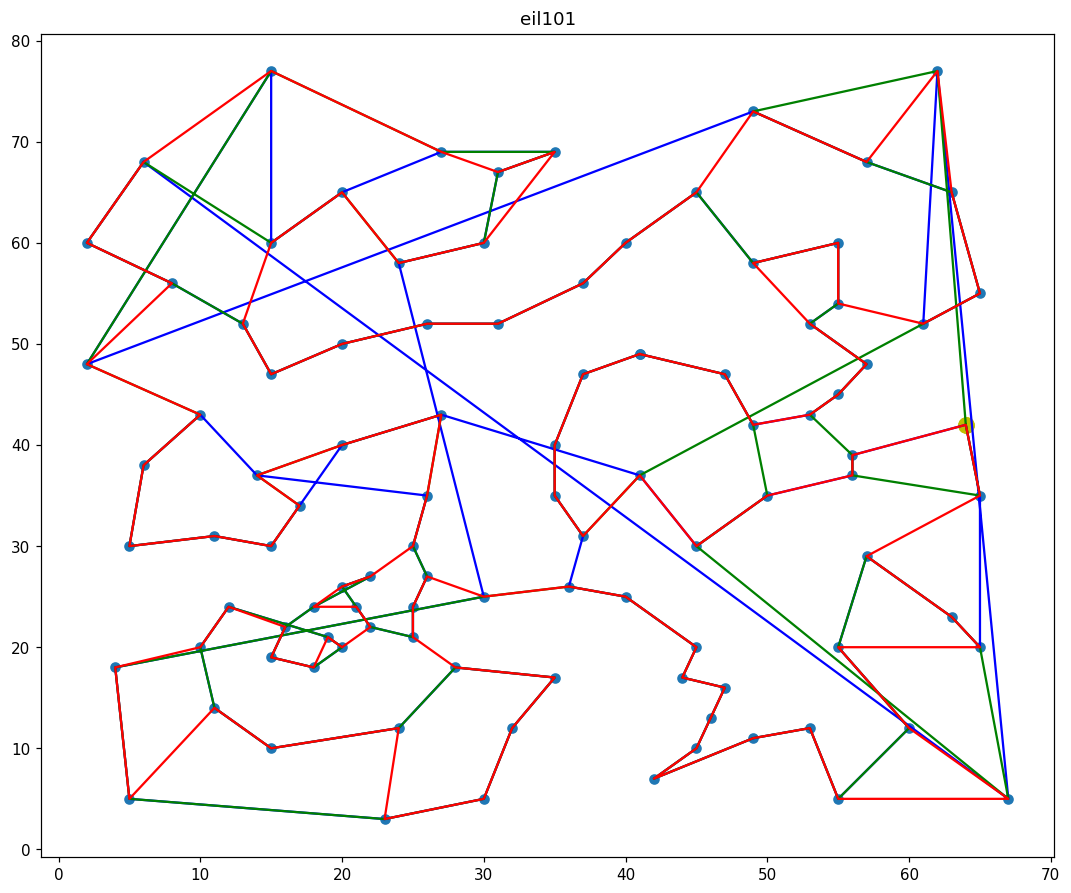

(red)   Optimal  Tour:    629   100.0%
(grn) Minimum NN Tour:    746   118.6%   (ylw) Start Node
(blu) Maximum NN Tour:    913   145.15%

  Average Tour Length:    832   132.27%

  1 tours of length    746:	[29]
  1 tours of length    762:	[54]
  2 tours of length    763:	[25, 55]
  1 tours of length    764:	[24]
  1 tours of length    773:	[39]
  1 tours of length    774:	[23]
  2 tours of length    777:	[4, 26]
  2 tours of length    778:	[67, 80]
  1 tours of length    780:	[56]
  2 tours of length    784:	[12, 72]
  5 tours of length    785:	[22, 33, 53, 75, 76]
  2 tours of length    786:	[68, 77]
  1 tours of length    787:	[40]
  2 tours of length    788:	[21, 73]
  2 tours of length    795:	[41, 50]
  1 tours of length    803:	[1]
  1 tours of length    806:	[44]
  3 tours of length    808:	[42, 58, 69]
  1 tours of length    809:	[9]
  1 tours of length    814:	[2]
  1 tours of length    815:	[101]
  1 tours of length    819:	[15]
  1 tours of length    820:	[20]
  1 tours of 

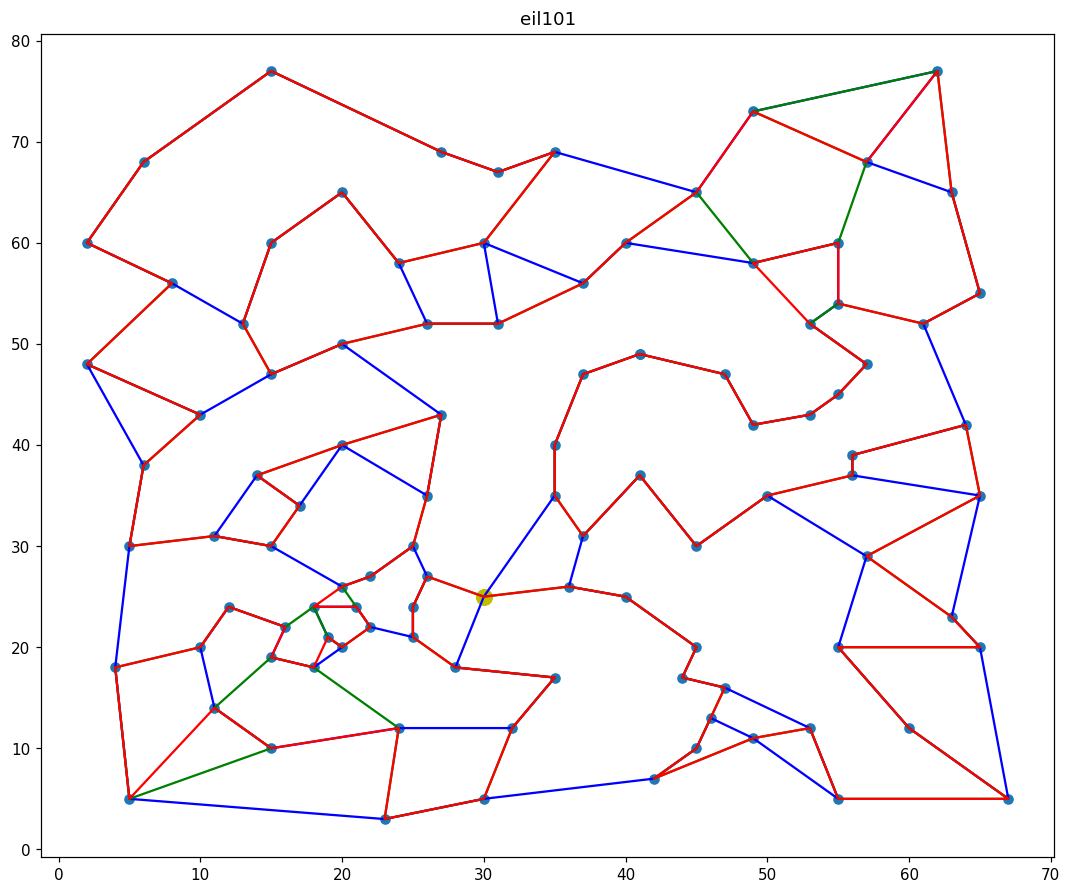

(red)   Optimal  Tour:    629   100.0%
(grn) Minimum NN Tour:    631   100.32%   (ylw) Start Node
(blu) Maximum NN Tour:    681   108.27%

  Average Tour Length:    656   104.29%


                        Min      Max      Ave

Perturbation loops:       3        6        4
         Effective:      30       78       53
       Ineffective:   14787    29653    20630

          Reversal:      11       42       24
       Rotate Left:       5       24       13
      Rotate Right:       3       20       11
          Exchange:       0       11        5
         Multiples:       5       23       13


  1 tours of length    631:	[13]
  1 tours of length    637:	[2]
  2 tours of length    638:	[15, 57]
  7 tours of length    642:	[9, 20, 25, 42, 58, 66, 77]
  3 tours of length    643:	[44, 50, 80]
  1 tours of length    644:	[33]
  3 tours of length    645:	[63, 98, 99]
  2 tours of length    647:	[29, 76]
  2 tours of length    648:	[61, 69]
  6 tours of length    649:	[39, 41, 48, 70, 85, 87]
 

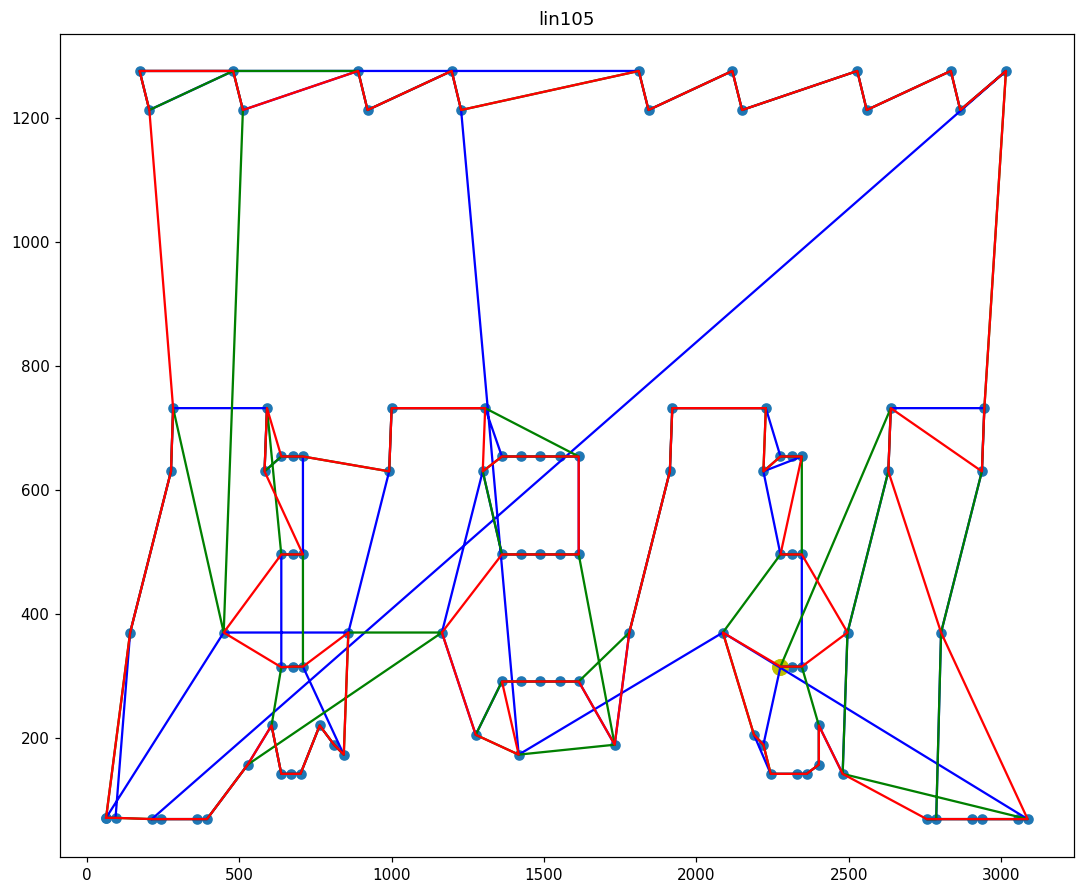

(red)   Optimal  Tour:  14379   100.0%
(grn) Minimum NN Tour:  16935   117.78%   (ylw) Start Node
(blu) Maximum NN Tour:  20584   143.15%

  Average Tour Length:  18710   130.12%

  1 tours of length  16935:	[72]
  1 tours of length  16952:	[73]
  2 tours of length  16996:	[64, 67]
  1 tours of length  17039:	[80]
  1 tours of length  17042:	[76]
  1 tours of length  17052:	[59]
  1 tours of length  17058:	[68]
  1 tours of length  17098:	[79]
  1 tours of length  17099:	[77]
  1 tours of length  17143:	[71]
  1 tours of length  17222:	[85]
  1 tours of length  17231:	[83]
  1 tours of length  17316:	[78]
  1 tours of length  17353:	[102]
  2 tours of length  17355:	[97, 101]
  1 tours of length  17363:	[96]
  1 tours of length  17369:	[82]
  1 tours of length  17396:	[63]
  1 tours of length  17473:	[84]
  1 tours of length  17511:	[49]
  1 tours of length  17642:	[99]
  1 tours of length  17812:	[86]
  1 tours of length  17840:	[62]
  1 tours of length  17890:	[88]
  1 tours of lengt

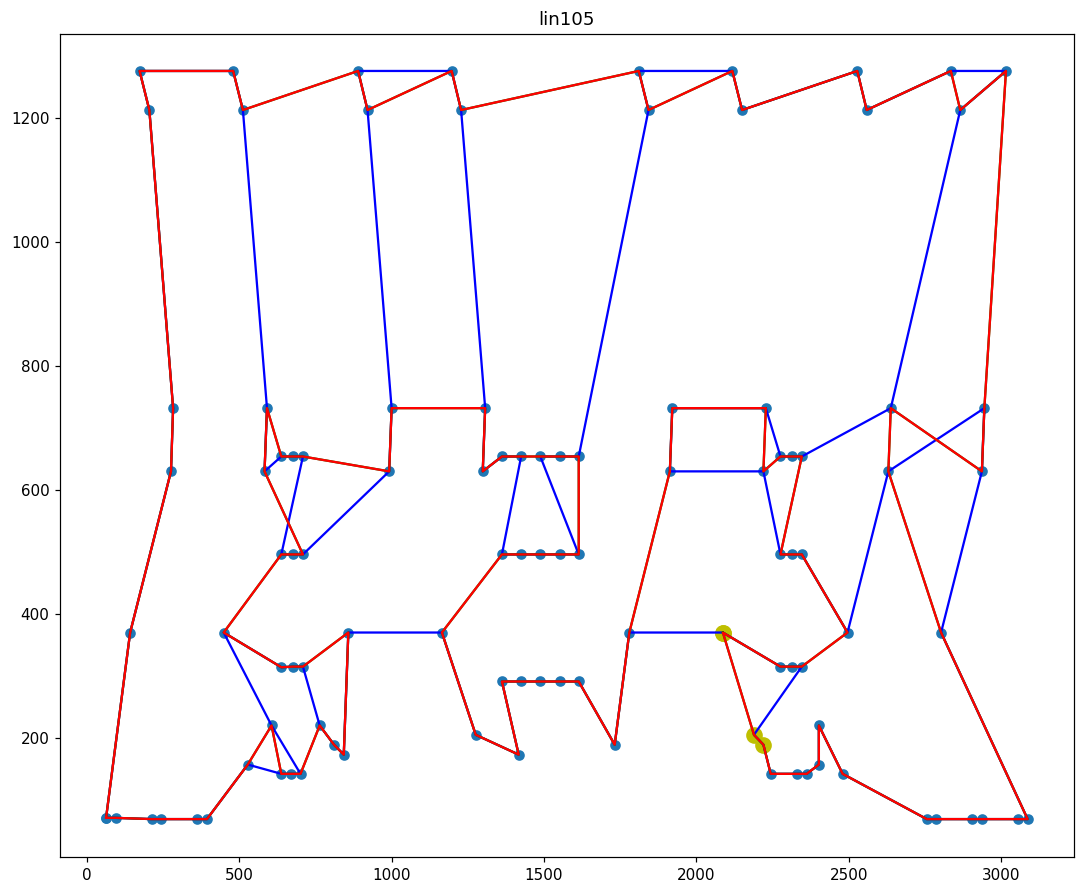

(red)   Optimal  Tour:  14379   100.0%
(grn) Minimum NN Tour:  14379   100.0%   (ylw) Start Node
(blu) Maximum NN Tour:  15961   111.0%

  Average Tour Length:  14983   104.2%


                        Min      Max      Ave

Perturbation loops:       3        7        5
         Effective:      35       87       58
       Ineffective:   15996    37433    24121

          Reversal:      12       42       26
       Rotate Left:       5       29       14
      Rotate Right:       5       21       12
          Exchange:       1       14        6
         Multiples:       7       27       16


  3 tours of length  14379:	[64, 67, 68]
  4 tours of length  14426:	[77, 79, 84, 97]
  9 tours of length  14468:	[1, 2, 9, 66, 87, 88, 94, 95, 100]
  1 tours of length  14475:	[83]
  1 tours of length  14490:	[47]
  1 tours of length  14508:	[85]
  3 tours of length  14514:	[60, 61, 76]
 10 tours of length  14515:	[6, 16, 18, 25, 26, 65, 96, 99, 101, 102]
  1 tours of length  14523:	[12]
  1 tours of

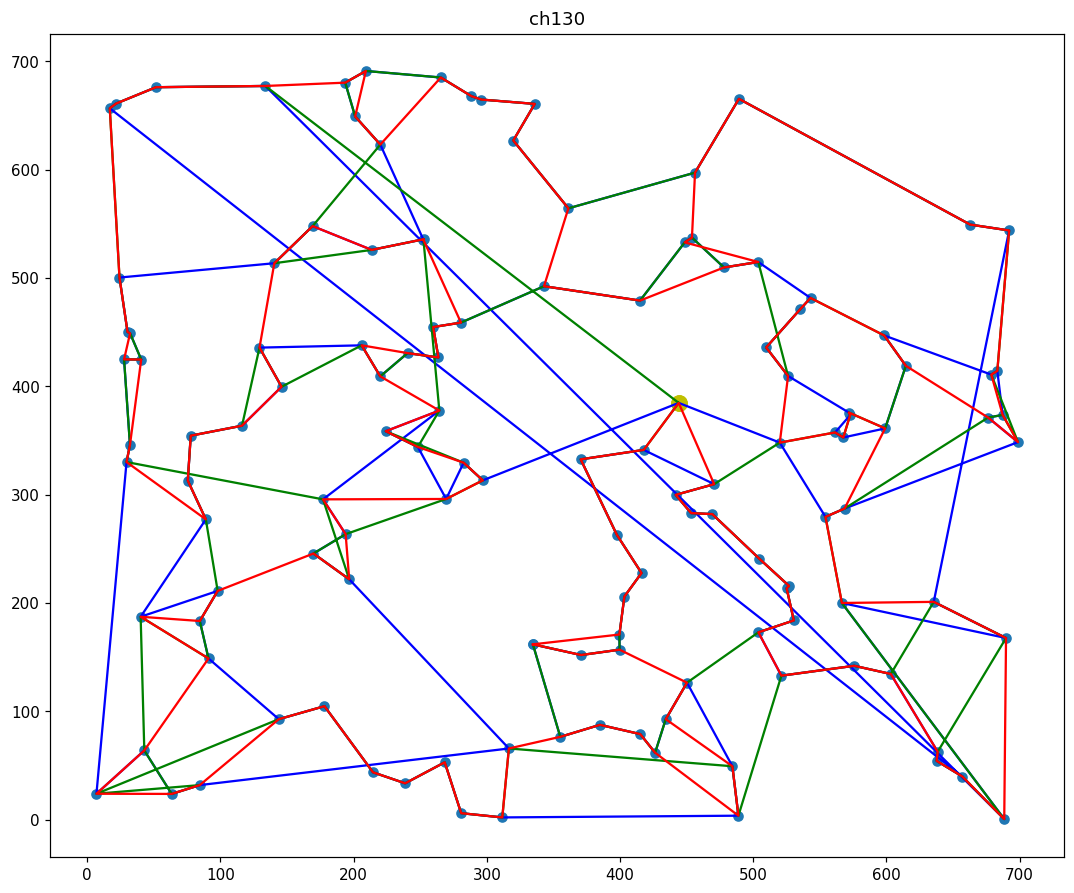

(red)   Optimal  Tour:   6110   100.0%
(grn) Minimum NN Tour:   7129   116.68%   (ylw) Start Node
(blu) Maximum NN Tour:   8837   144.63%

  Average Tour Length:   7736   126.61%

  1 tours of length   7129:	[4]
  1 tours of length   7192:	[103]
  1 tours of length   7196:	[77]
  1 tours of length   7206:	[54]
  1 tours of length   7228:	[99]
  1 tours of length   7229:	[73]
  1 tours of length   7261:	[74]
  1 tours of length   7275:	[78]
  1 tours of length   7277:	[75]
  1 tours of length   7307:	[126]
  1 tours of length   7331:	[35]
  1 tours of length   7341:	[12]
  1 tours of length   7342:	[87]
  1 tours of length   7358:	[8]
  1 tours of length   7360:	[114]
  1 tours of length   7363:	[108]
  1 tours of length   7366:	[81]
  1 tours of length   7379:	[111]
  1 tours of length   7381:	[123]
  1 tours of length   7383:	[65]
  2 tours of length   7385:	[82, 101]
  1 tours of length   7386:	[57]
  1 tours of length   7392:	[9]
  1 tours of length   7395:	[30]
  1 tours of length 

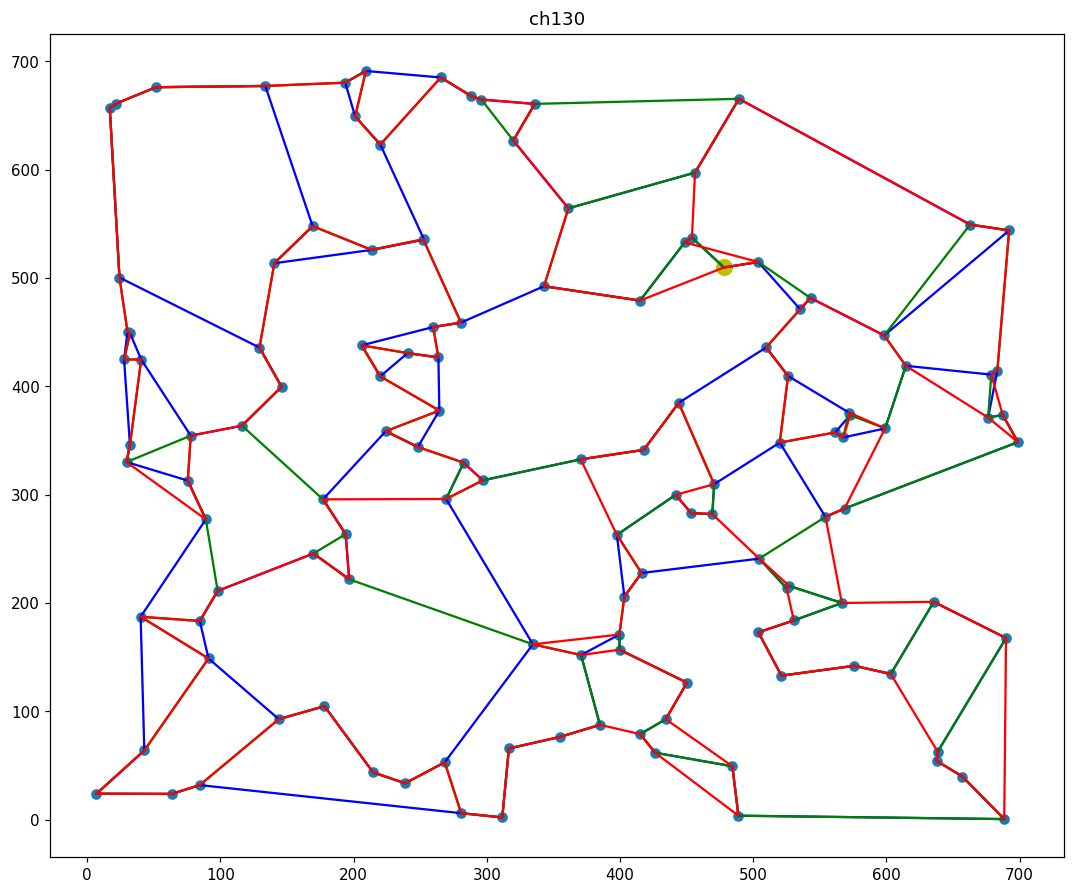

(red)   Optimal  Tour:   6110   100.0%
(grn) Minimum NN Tour:   6202   101.51%   (ylw) Start Node
(blu) Maximum NN Tour:   6825   111.7%

  Average Tour Length:   6455   105.65%


                        Min      Max      Ave

Perturbation loops:       3       11        5
         Effective:      36      114       62
       Ineffective:   24702    90722    37535

          Reversal:      22       63       34
       Rotate Left:       1       23       12
      Rotate Right:       2       27       11
          Exchange:       1       15        5
         Multiples:       5       32       14


  1 tours of length   6202:	[53]
  1 tours of length   6218:	[126]
  1 tours of length   6227:	[4]
  1 tours of length   6244:	[124]
  1 tours of length   6245:	[12]
  1 tours of length   6253:	[55]
  1 tours of length   6255:	[87]
  1 tours of length   6256:	[32]
  1 tours of length   6257:	[91]
  1 tours of length   6267:	[114]
  1 tours of length   6272:	[121]
  1 tours of length   6279:	[63]
  1

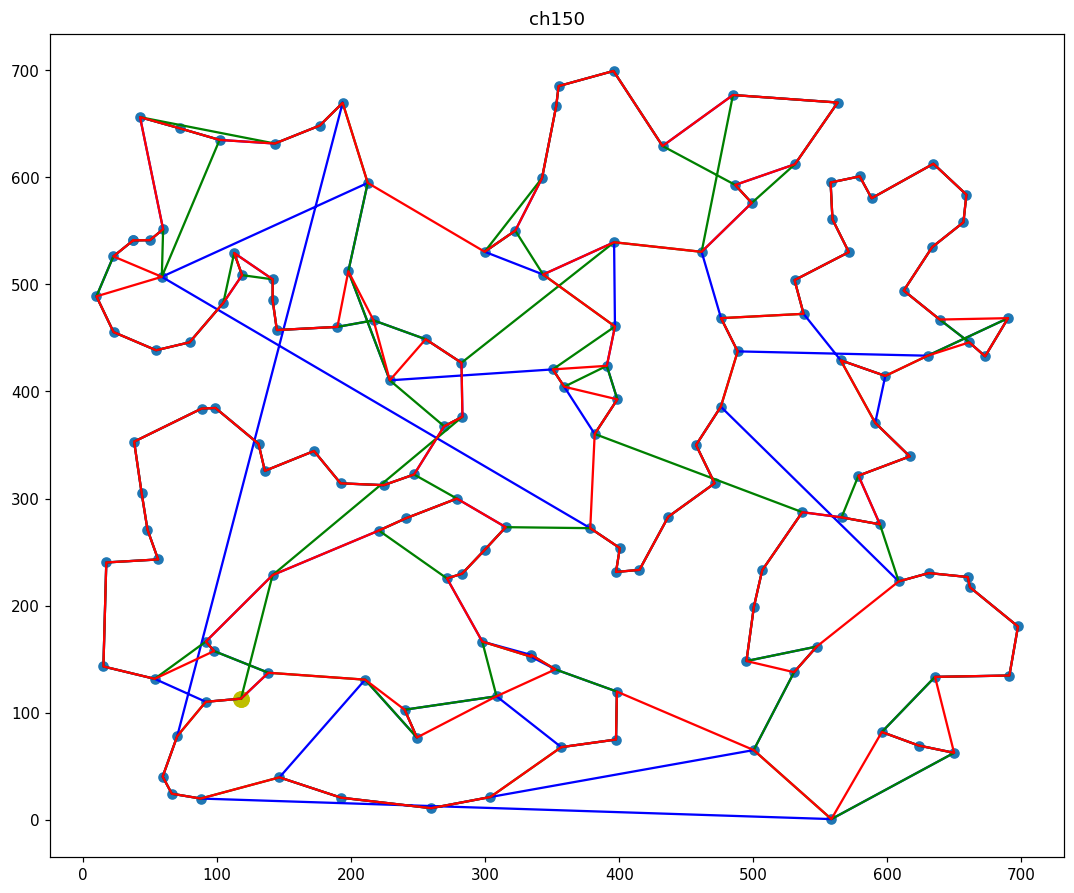

(red)   Optimal  Tour:   6528   100.0%
(grn) Minimum NN Tour:   7113   108.96%   (ylw) Start Node
(blu) Maximum NN Tour:   8349   127.9%

  Average Tour Length:   7672   117.52%

  1 tours of length   7113:	[71]
  3 tours of length   7129:	[13, 91, 128]
  3 tours of length   7140:	[22, 113, 125]
  1 tours of length   7157:	[10]
  1 tours of length   7174:	[116]
  1 tours of length   7176:	[68]
  1 tours of length   7184:	[119]
  1 tours of length   7210:	[149]
  1 tours of length   7227:	[145]
  2 tours of length   7260:	[82, 95]
  1 tours of length   7290:	[43]
  1 tours of length   7296:	[136]
  1 tours of length   7308:	[51]
  3 tours of length   7309:	[5, 107, 124]
  1 tours of length   7314:	[112]
  1 tours of length   7329:	[74]
  1 tours of length   7331:	[109]
  1 tours of length   7363:	[32]
  1 tours of length   7386:	[44]
  1 tours of length   7402:	[123]
  1 tours of length   7424:	[104]
  1 tours of length   7429:	[39]
  1 tours of length   7432:	[106]
  1 tours of length 

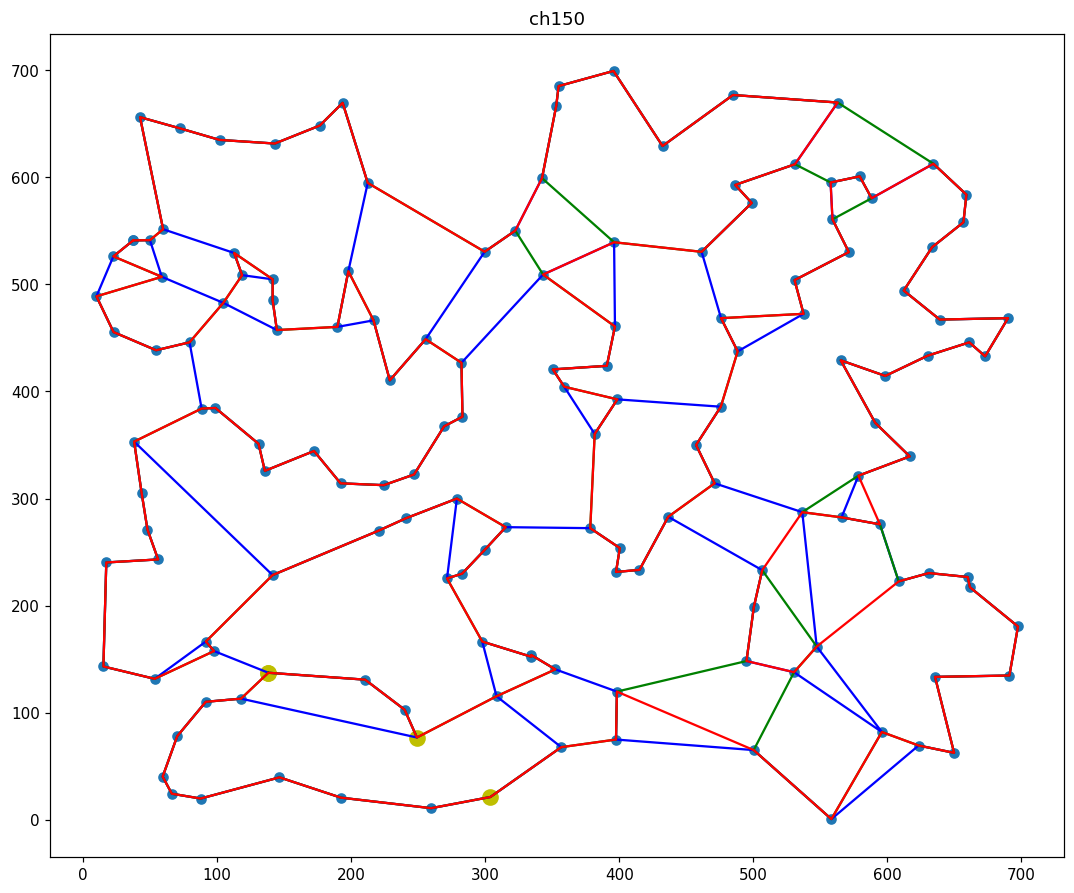

(red)   Optimal  Tour:   6528   100.0%
(grn) Minimum NN Tour:   6566   100.58%   (ylw) Start Node
(blu) Maximum NN Tour:   7069   108.29%

  Average Tour Length:   6723   102.99%


                        Min      Max      Ave

Perturbation loops:       3        7        4
         Effective:      26       80       47
       Ineffective:   33024    77125    45747

          Reversal:      10       38       22
       Rotate Left:       2       25       11
      Rotate Right:       1       23       10
          Exchange:       0       14        4
         Multiples:       4       30       12


  3 tours of length   6566:	[44, 123, 136]
  1 tours of length   6584:	[115]
  3 tours of length   6589:	[7, 104, 126]
  7 tours of length   6590:	[13, 22, 113, 119, 125, 128, 149]
  1 tours of length   6592:	[145]
  5 tours of length   6596:	[10, 68, 71, 91, 106]
  1 tours of length   6598:	[74]
  1 tours of length   6602:	[5]
  2 tours of length   6610:	[59, 111]
  1 tours of length   6612:	[121]

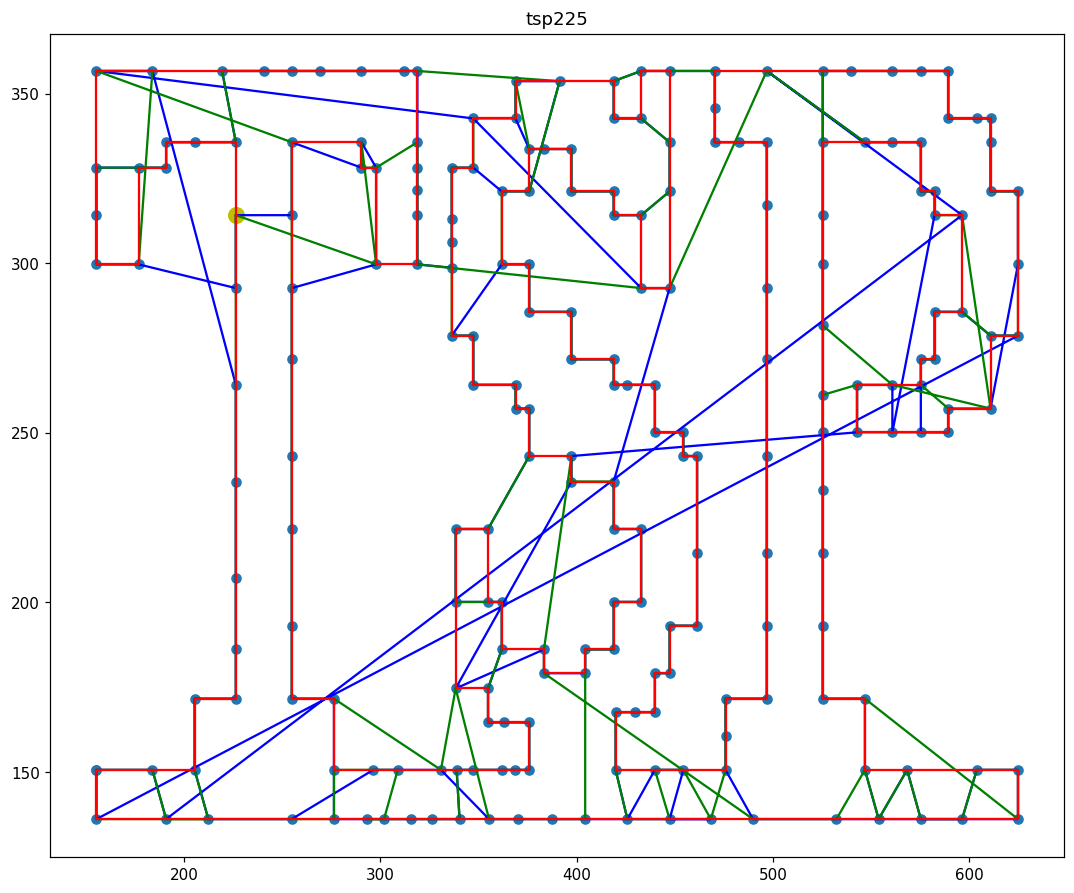

(red)   Optimal  Tour:   3861   100.0%
(grn) Minimum NN Tour:   4557   118.03%   (ylw) Start Node
(blu) Maximum NN Tour:   5603   145.12%

  Average Tour Length:   5092   131.88%

  1 tours of length   4557:	[12]
  1 tours of length   4570:	[16]
  1 tours of length   4573:	[22]
  1 tours of length   4584:	[18]
  1 tours of length   4591:	[17]
  1 tours of length   4594:	[21]
  1 tours of length   4595:	[91]
  1 tours of length   4599:	[92]
  1 tours of length   4608:	[15]
  1 tours of length   4614:	[20]
  2 tours of length   4624:	[203, 210]
  2 tours of length   4637:	[88, 90]
  1 tours of length   4643:	[19]
  1 tours of length   4651:	[89]
  1 tours of length   4660:	[95]
  1 tours of length   4674:	[32]
  1 tours of length   4710:	[31]
  1 tours of length   4722:	[1]
  1 tours of length   4723:	[5]
  1 tours of length   4725:	[7]
  1 tours of length   4726:	[4]
  1 tours of length   4727:	[35]
  1 tours of length   4731:	[200]
  2 tours of length   4734:	[70, 217]
  1 tours of len

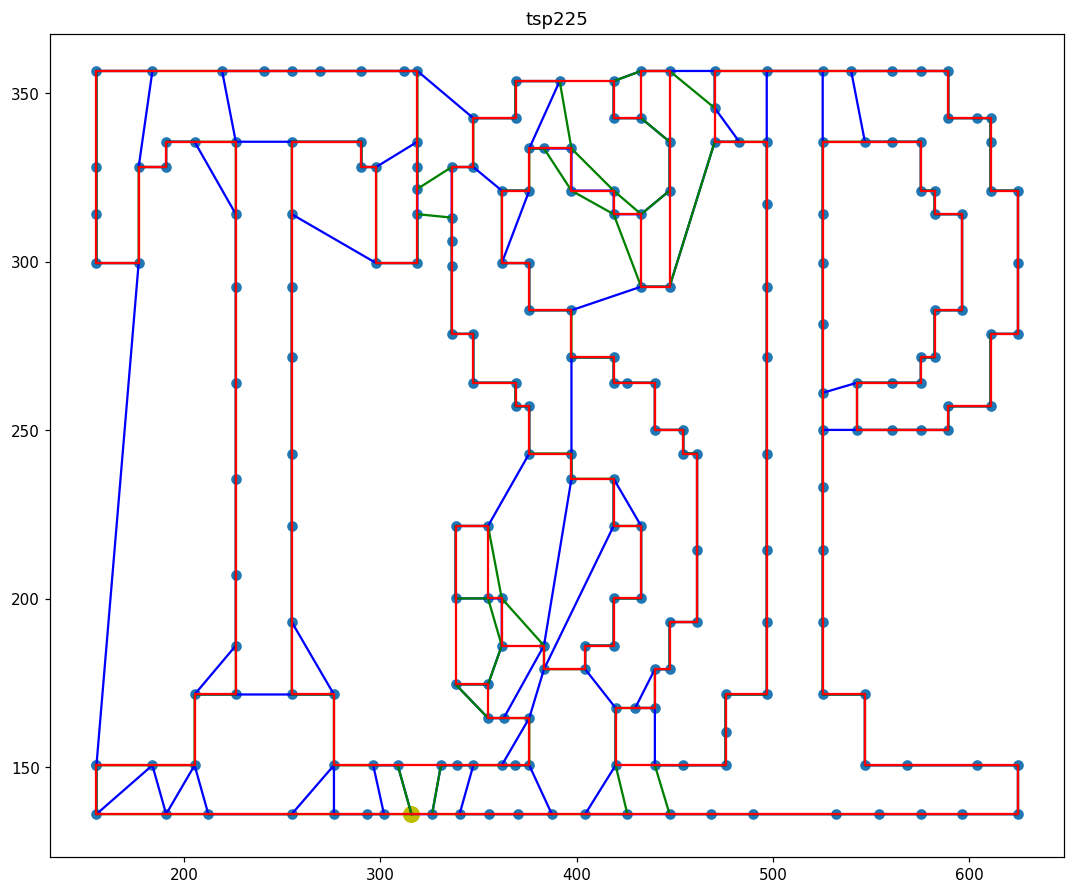

(red)   Optimal  Tour:   3861   100.0%
(grn) Minimum NN Tour:   3934   101.89%   (ylw) Start Node
(blu) Maximum NN Tour:   4210   109.04%

  Average Tour Length:   4045   104.77%


                        Min      Max      Ave

Perturbation loops:       4        8        5
         Effective:      67      157      113
       Ineffective:   99749   199658   119327

          Reversal:      27       73       50
       Rotate Left:      11       44       27
      Rotate Right:      12       46       26
          Exchange:       4       20       10
         Multiples:       6       47       27


  1 tours of length   3934:	[196]
  2 tours of length   3952:	[14, 202]
  1 tours of length   3953:	[201]
  1 tours of length   3961:	[126]
  3 tours of length   3964:	[51, 52, 85]
  1 tours of length   3965:	[204]
  2 tours of length   3966:	[19, 94]
  1 tours of length   3967:	[182]
  1 tours of length   3969:	[7]
  1 tours of length   3970:	[50]
  1 tours of length   3971:	[42]
  1 tours of leng

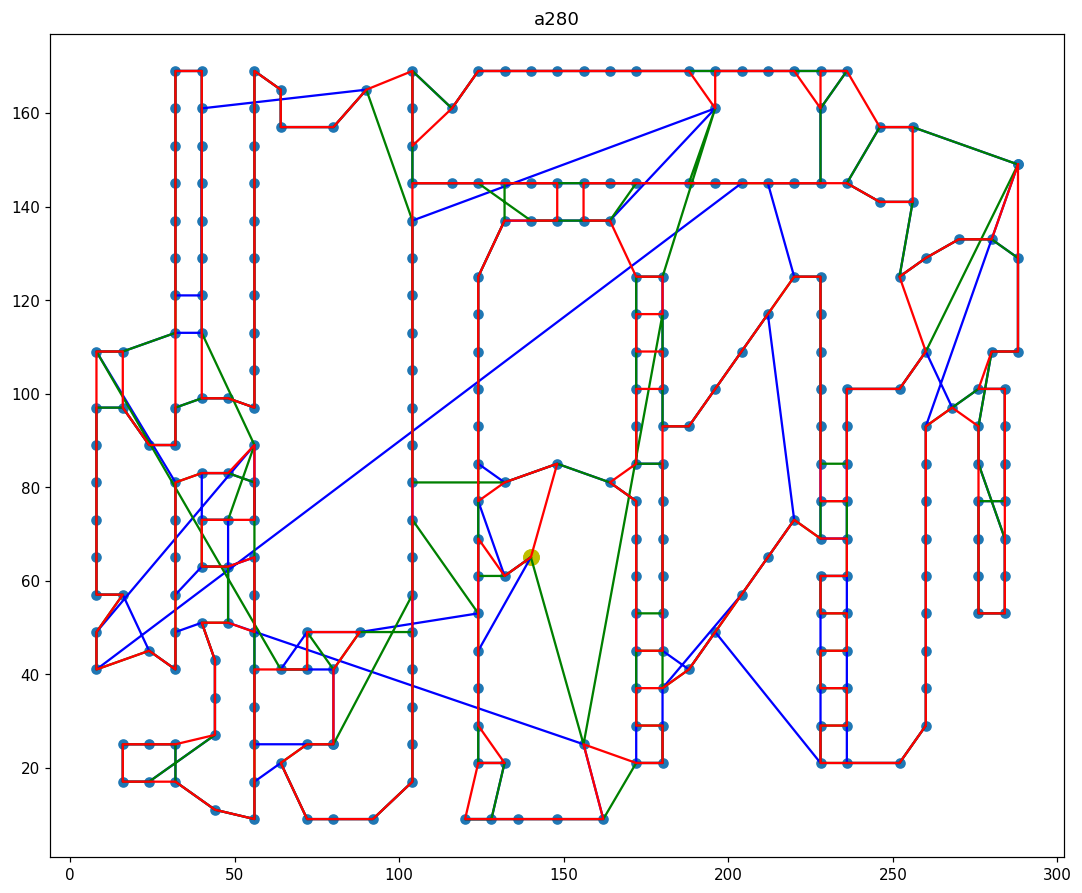

(red)   Optimal  Tour:   2579   100.0%
(grn) Minimum NN Tour:   2975   115.35%   (ylw) Start Node
(blu) Maximum NN Tour:   3417   132.49%

  Average Tour Length:   3172   122.99%

  1 tours of length   2975:	[179]
  1 tours of length   2976:	[186]
  1 tours of length   2982:	[184]
  1 tours of length   2986:	[190]
  1 tours of length   2987:	[185]
  1 tours of length   2989:	[189]
  2 tours of length   2990:	[191, 192]
  2 tours of length   2992:	[178, 187]
  2 tours of length   2998:	[163, 164]
  1 tours of length   3006:	[165]
  2 tours of length   3021:	[162, 175]
  1 tours of length   3022:	[153]
  1 tours of length   3041:	[193]
  1 tours of length   3043:	[160]
  1 tours of length   3053:	[159]
  1 tours of length   3063:	[158]
  2 tours of length   3065:	[168, 221]
  1 tours of length   3066:	[217]
  1 tours of length   3070:	[213]
  1 tours of length   3073:	[220]
  2 tours of length   3076:	[207, 216]
  1 tours of length   3078:	[188]
  2 tours of length   3081:	[144, 212]
  7

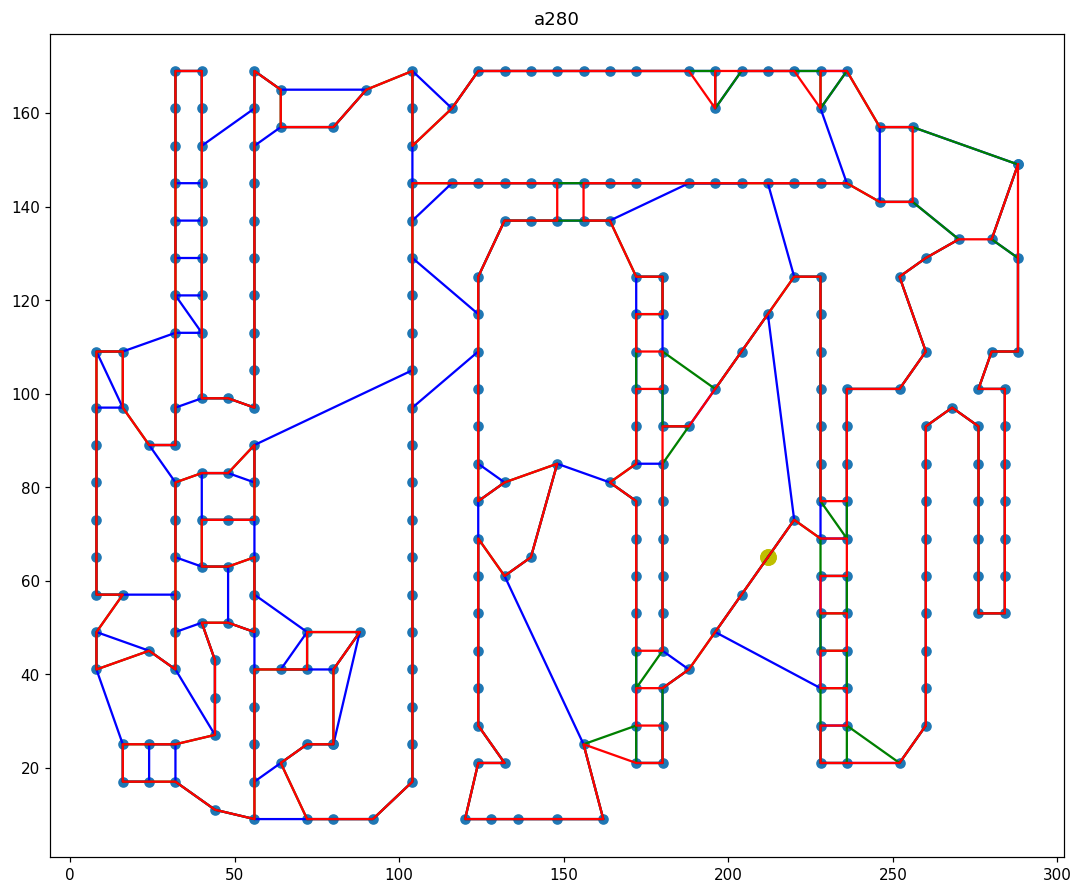

(red)   Optimal  Tour:   2579   100.0%
(grn) Minimum NN Tour:   2609   101.16%   (ylw) Start Node
(blu) Maximum NN Tour:   2852   110.59%

  Average Tour Length:   2702   104.77%


                        Min      Max      Ave

Perturbation loops:       3        9        5
         Effective:      63      135       90
       Ineffective:  116246   348920   175671

          Reversal:      22       55       37
       Rotate Left:      11       42       24
      Rotate Right:      12       41       24
          Exchange:       0       12        5
         Multiples:       7       29       15


  1 tours of length   2609:	[205]
  1 tours of length   2615:	[273]
  1 tours of length   2624:	[249]
  2 tours of length   2628:	[19, 178]
  1 tours of length   2629:	[4]
  1 tours of length   2633:	[179]
  2 tours of length   2634:	[20, 275]
  2 tours of length   2635:	[155, 207]
  1 tours of length   2636:	[16]
  2 tours of length   2638:	[29, 209]
  1 tours of length   2643:	[115]
  1 tours of 

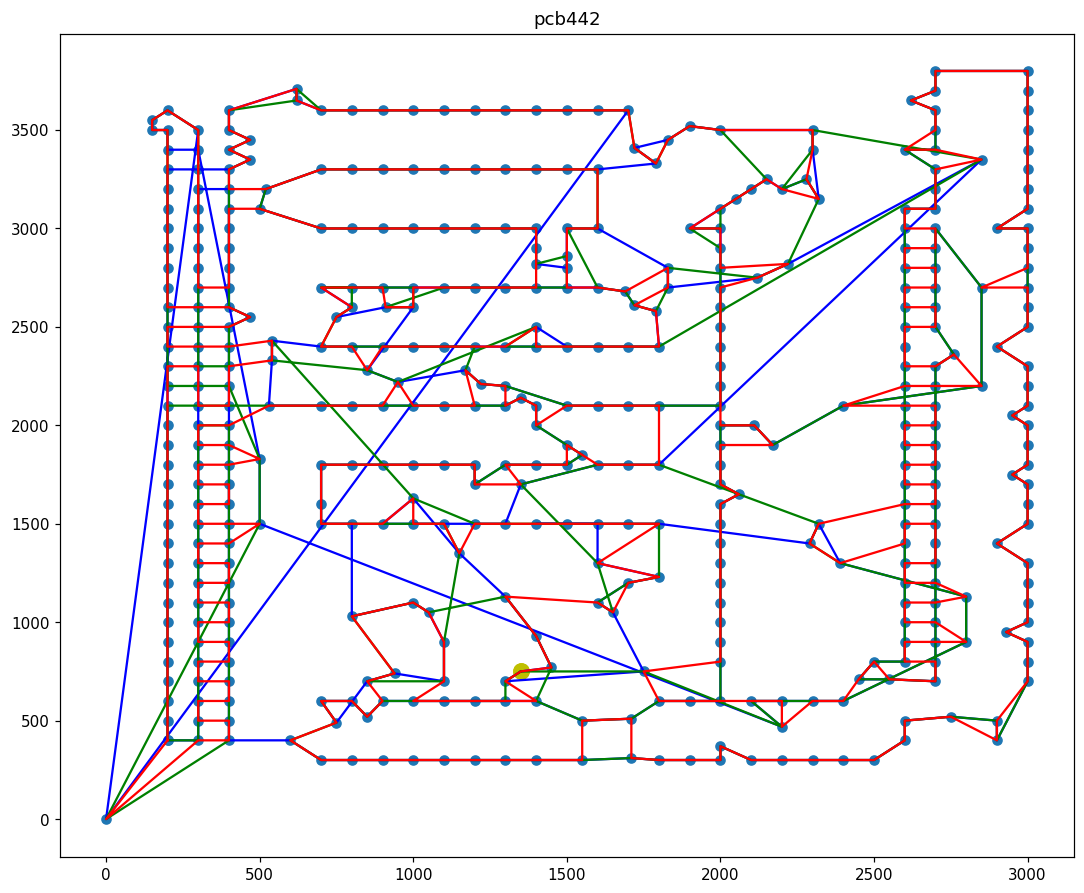

(red)   Optimal  Tour:  50778   100.0%
(grn) Minimum NN Tour:  58950   116.09%   (ylw) Start Node
(blu) Maximum NN Tour:  66158   130.29%

  Average Tour Length:  62249   122.59%

  1 tours of length  58950:	[396]
  1 tours of length  58990:	[173]
  1 tours of length  59045:	[162]
  1 tours of length  59138:	[151]
  1 tours of length  59229:	[405]
  1 tours of length  59378:	[178]
  1 tours of length  59683:	[108]
  1 tours of length  59696:	[165]
  1 tours of length  59735:	[7]
  1 tours of length  59750:	[8]
  1 tours of length  59788:	[177]
  1 tours of length  59808:	[9]
  1 tours of length  59897:	[231]
  1 tours of length  59947:	[10]
  1 tours of length  59980:	[74]
  1 tours of length  59992:	[75]
  1 tours of length  60047:	[76]
  1 tours of length  60049:	[43]
  1 tours of length  60064:	[44]
  1 tours of length  60093:	[99]
  1 tours of length  60100:	[311]
  2 tours of length  60121:	[45, 310]
  1 tours of length  60125:	[250]
  1 tours of length  60138:	[15]
  1 tours of l

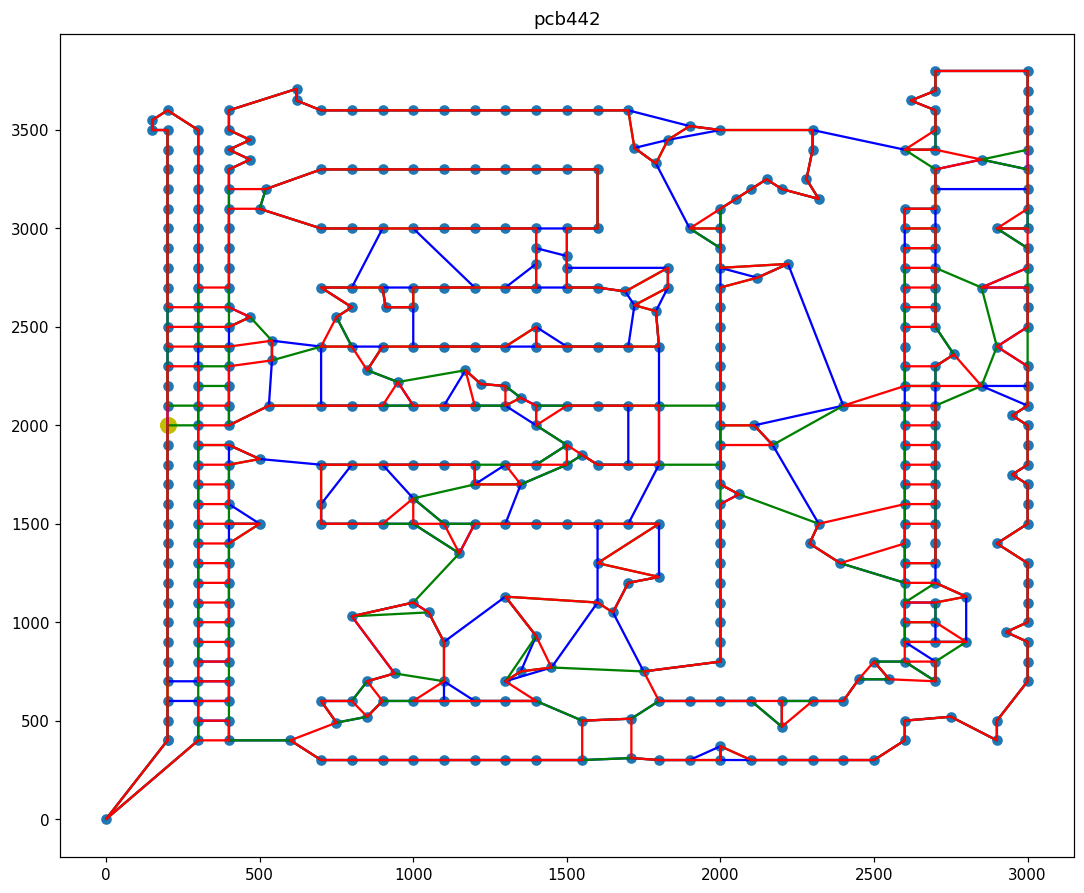

(red)   Optimal  Tour:  50778   100.0%
(grn) Minimum NN Tour:  51681   101.78%   (ylw) Start Node
(blu) Maximum NN Tour:  54611   107.55%

  Average Tour Length:  52839   104.06%


                        Min      Max      Ave

Perturbation loops:       3       13        5
         Effective:     110      214      147
       Ineffective:  290944   1261085   489123

          Reversal:      35       98       59
       Rotate Left:      22       73       41
      Rotate Right:      22       65       40
          Exchange:       1       27        8
         Multiples:      11       67       26


  1 tours of length  51681:	[17]
  1 tours of length  51818:	[108]
  1 tours of length  51844:	[11]
  1 tours of length  51889:	[157]
  1 tours of length  51894:	[122]
  1 tours of length  51895:	[55]
  1 tours of length  51919:	[99]
  1 tours of length  51921:	[393]
  1 tours of length  51935:	[109]
  1 tours of length  51936:	[138]
  1 tours of length  51941:	[104]
  1 tours of length  51942:	[5

In [113]:
print( 'Started\n')
showAllNN( '.\\ALL_tsp' )